In [3]:
# Library import cell

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import itertools
from scipy.optimize import curve_fit
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Function cell

def generate_random_binary_string(length):
    binary_string = ''.join(np.random.choice(['0', '1'], size=length))
    return binary_string

def generate_dict(n_tasks, len_taskcode, num_checks, len_message):
    unique_strings = set()
    tasks_dict = {}
    if n_tasks > np.power(2, len_taskcode):
        print("Error: n_tasks is too large")
        return False
    while len(unique_strings) < n_tasks:
        binary_string = generate_random_binary_string(len_taskcode)
        if binary_string not in unique_strings:
            unique_strings.add(binary_string)
            integer_list = np.random.choice(range(len_message), size=num_checks, replace=False).tolist()
            tasks_dict[binary_string] = integer_list
    return tasks_dict

# Currently following a probability distribution given by the probabilities list
def generate_dataset(tasks_dict, num_samples):
    data = np.zeros((num_samples, len_taskcode + len_message))
    value = np.zeros(num_samples)
    
    task_list = list(tasks_dict)
    rank = np.arange(1, len(task_list) + 1)
    #probabilities = [1/(x**2) for x in rank]
    #probabilities = [np.exp(-0.1*x) for x in rank]
    #probabilities = [0.9, 0.09, 0.009, 0.001]
    probabilities = [1/(2**x) for x in rank]
    task_probabilities = probabilities / np.sum(probabilities)  # normalize probabilities
    #print('tasks dict = ', tasks_dict)
    #print('task_probabilities = ', task_probabilities)
    for i in range(num_samples):
        rand_task = np.random.choice(task_list, p=task_probabilities)
        rand_checkbits = tasks_dict[rand_task]
        message = generate_random_binary_string(len_message)
        parity_bit = 0
        for j in rand_checkbits:
            parity_bit += int(message[j])
        parity = parity_bit % 2
        data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
        value[i] = parity
    
    return [data, value]

def generate_dataset_for_task(task_code, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = task_code
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]

# IS NOT USING BATCH NORMALISATION
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        
        x = self.layers[-1](x)
        return x

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.iloc[:, :-1].values
        self.target = dataframe.iloc[:, -1].values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        y = torch.tensor(self.target[idx]).float()
        return x, y

In [5]:
# Plotting functions

def epoch_plots(num_epochs, loss_list, accuracy_list):
    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the training and test losses on the first subplot
    axs[0].plot(range(1, num_epochs+1), loss_list, label='Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot the training and test accuracies on the second subplot
    axs[1].plot(range(1, num_epochs+1), accuracy_list, label='Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Adjust the spacing between subplots
    #plt.tight_layout()
    plt.suptitle(f'Model performance')
    # Show the subplots
    plt.show()
    
    return

def acc_by_task_plot(moving_avg, num_epochs, task_sample_freq, accuracy_array):
    eff_num_epochs = math.ceil(num_epochs / task_sample_freq)
    # Calculate the filtered epochs
    moving_avg = len(accuracy_array)
    epochs = np.arange(0, eff_num_epochs, moving_avg)
    filtered_epochs = epochs[:len(epochs)//moving_avg * moving_avg] #NOTE: I do not understand this +1 and it may be cause for many many bugs down the line sorry
    scaled_filtered_epochs = [x * task_sample_freq for x in filtered_epochs]
    # Create an empty DataFrame
    df = pd.DataFrame()

    # Loop over the tasks and reshape the accuracy array
    for i in range(n_tasks): # THere is strange bug I don't understand when moving_avg is certain values, such as 4
        reshaped_accuracy_array = np.reshape(accuracy_array[i], (-1, moving_avg))
        # Create a temporary DataFrame for the current task
        temp_df = pd.DataFrame({
            'Epochs': np.repeat(scaled_filtered_epochs, moving_avg),
            'Accuracy': np.ndarray.flatten(reshaped_accuracy_array),
            'Task': i + 1
        })

        # Concatenate the temporary DataFrame to the main DataFrame
        df = pd.concat([df, temp_df])

    # Define the color map
    color_map = 'coolwarm'  # Change the color map here

    # Plotting the data using seaborn
    sns.lineplot(data=df, x='Epochs', y='Accuracy', errorbar=('ci', 95), estimator='mean', hue='Task', palette=color_map)

    # Add plot labels and legend
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epochs')

    sm = plt.cm.ScalarMappable(cmap=color_map)
    sm.set_array(range(1, n_tasks + 1))
    #plt.colorbar(sm, ticks=np.arange(1, n_tasks + 1, int(n_tasks+1)/10), label='Task Number')
    plt.colorbar(sm, ticks=np.linspace(1, n_tasks + 2, n_tasks+1, dtype=int), label='Task Number')

    # Remove the legend inside the plot
    plt.legend().remove()

    # Show the plot
    plt.show()
    return

tasks_dict =  dict_items([('10100010', [1, 5, 2]), ('10110000', [7, 1, 2]), ('10101100', [6, 7, 0]), ('11010111', [2, 1, 0]), ('10001010', [0, 4, 6]), ('00001011', [0, 7, 1]), ('00001001', [5, 3, 4]), ('11101111', [0, 7, 2]), ('01000011', [7, 6, 3]), ('10100100', [3, 0, 4]), ('10000111', [0, 1, 5]), ('00110011', [1, 0, 4]), ('10100000', [6, 2, 5]), ('01110100', [7, 4, 5]), ('10010011', [2, 6, 7]), ('10111100', [6, 1, 4])])


  2%|▏         | 200/10000 [07:51<6:03:14,  2.22s/it]

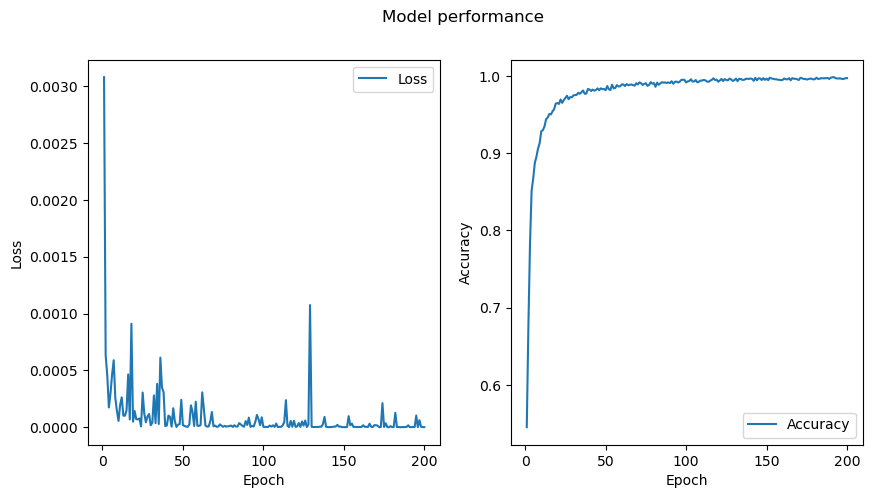

  4%|▍         | 400/10000 [16:34<6:41:06,  2.51s/it] 

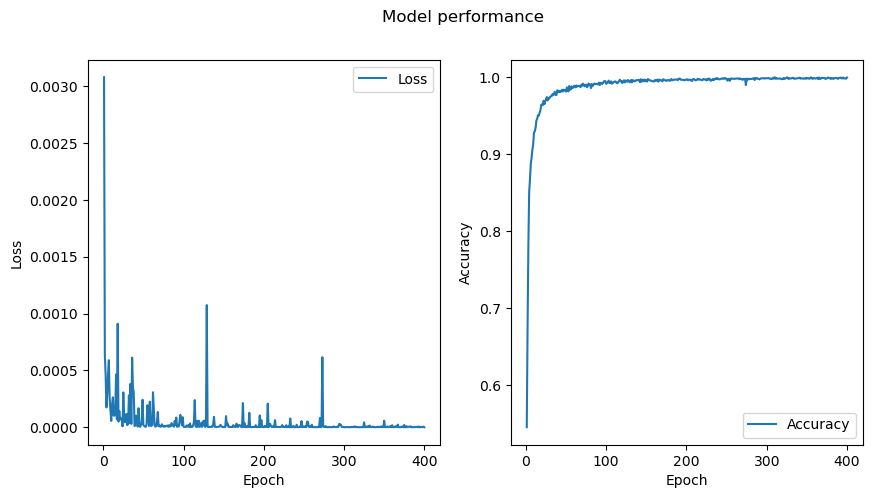

  6%|▌         | 600/10000 [24:00<5:18:46,  2.03s/it] 

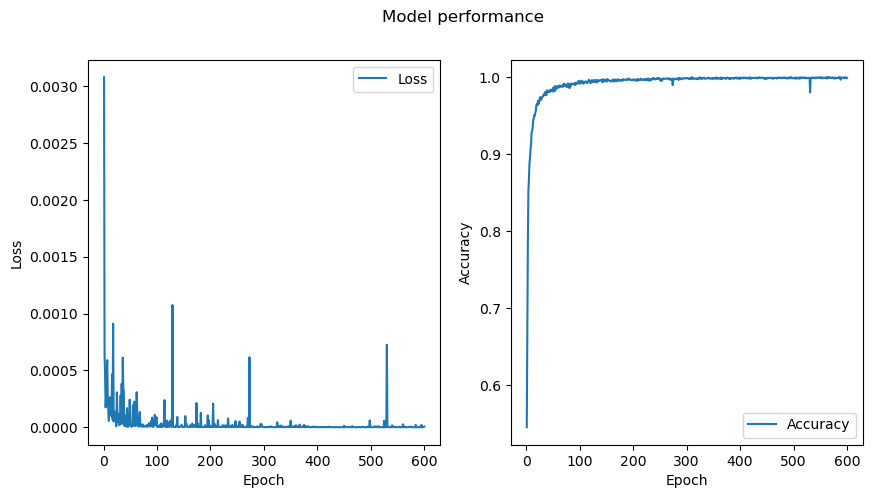

  8%|▊         | 800/10000 [32:14<5:05:31,  1.99s/it] 

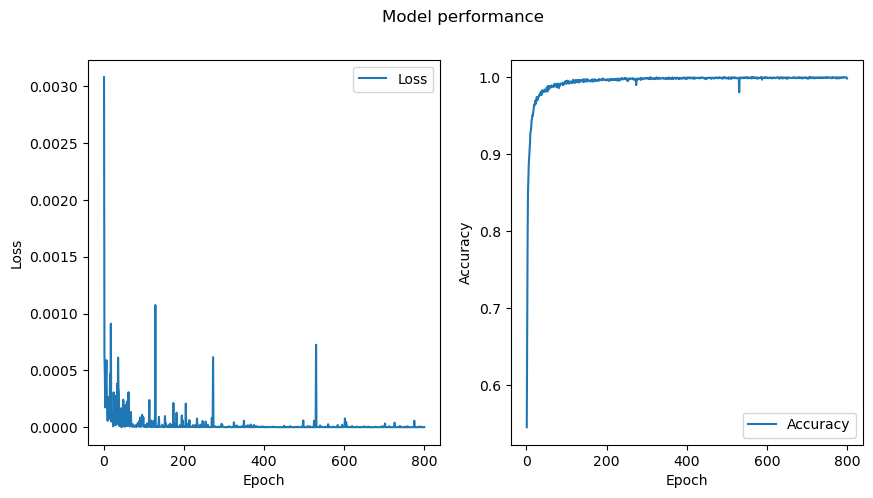

 10%|█         | 1000/10000 [41:12<7:16:42,  2.91s/it]

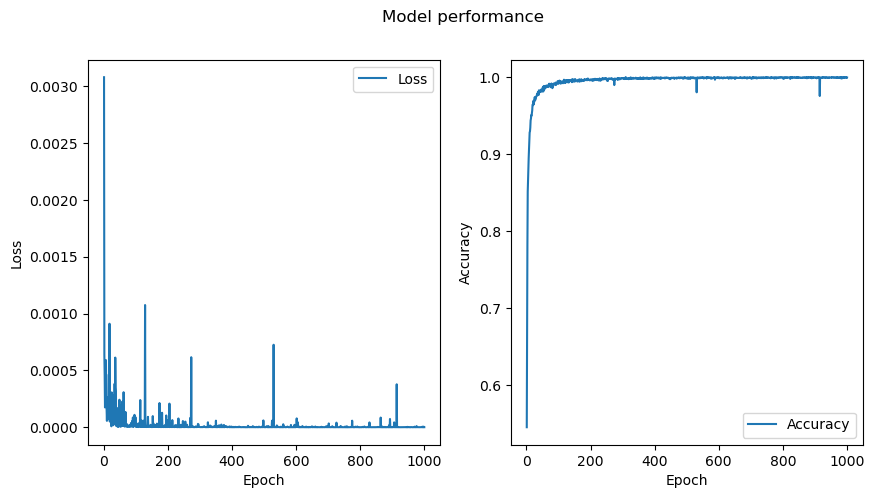

 12%|█▏        | 1200/10000 [49:31<4:56:30,  2.02s/it] 

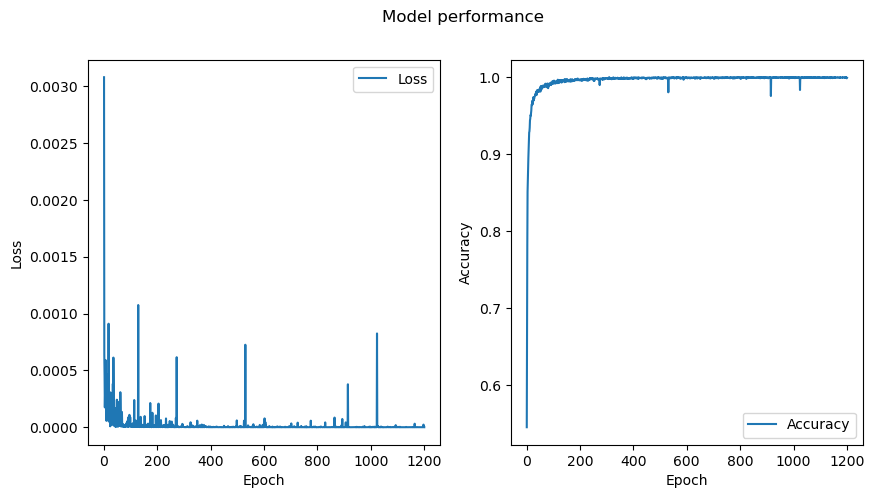

 14%|█▍        | 1400/10000 [57:55<5:47:12,  2.42s/it]

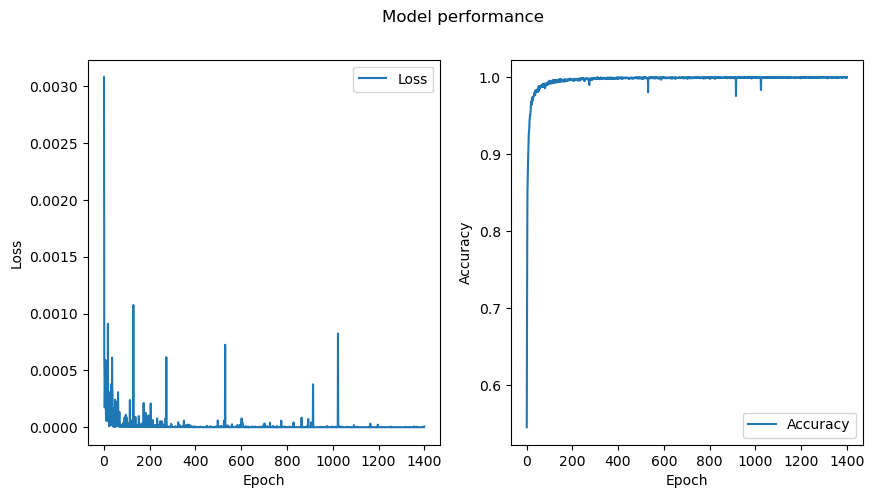

 16%|█▌        | 1600/10000 [1:05:45<4:50:36,  2.08s/it]

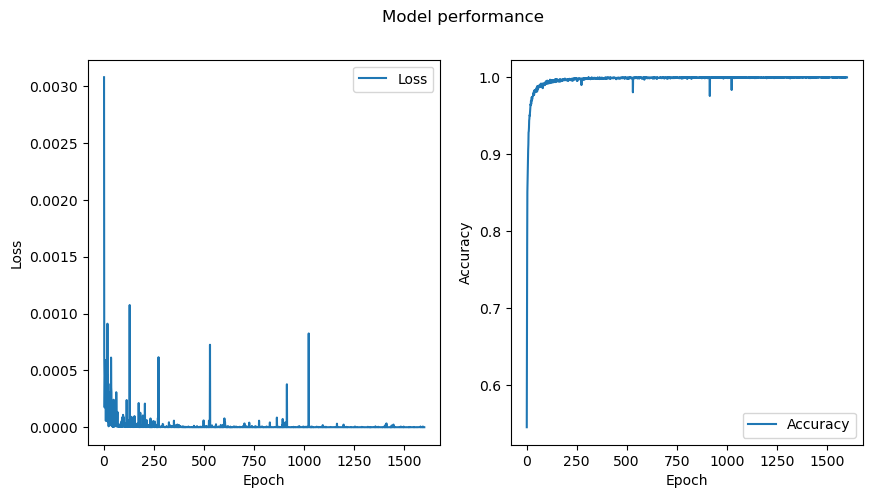

 18%|█▊        | 1800/10000 [1:13:46<4:56:00,  2.17s/it]

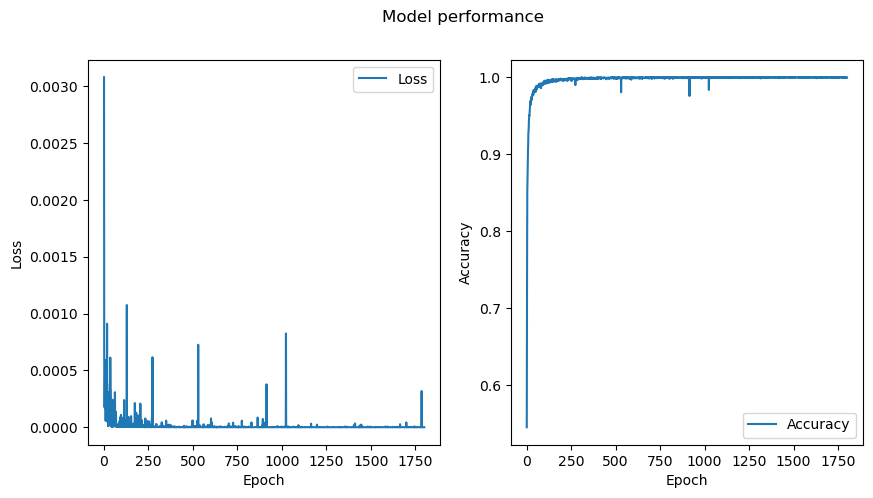

 20%|██        | 2000/10000 [1:24:28<6:30:23,  2.93s/it] 

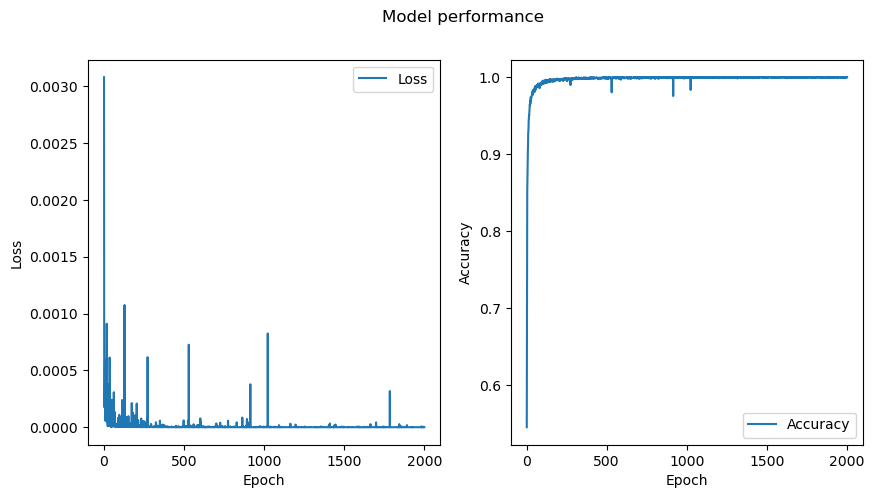

 22%|██▏       | 2200/10000 [1:34:38<6:28:13,  2.99s/it] 

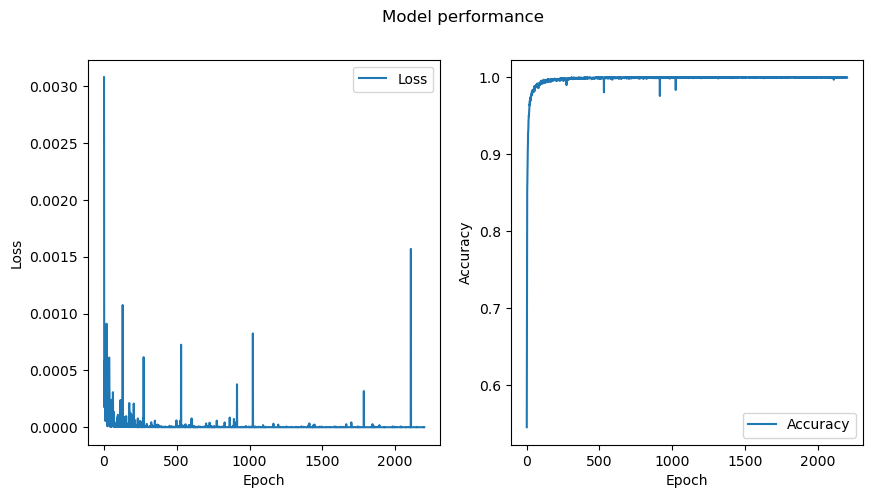

 24%|██▍       | 2400/10000 [1:45:05<6:24:52,  3.04s/it]

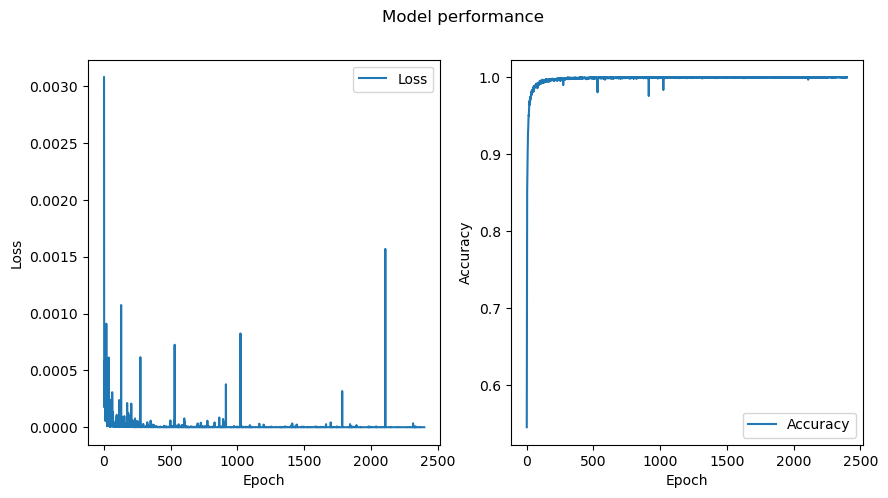

 26%|██▌       | 2600/10000 [1:55:22<6:10:43,  3.01s/it]

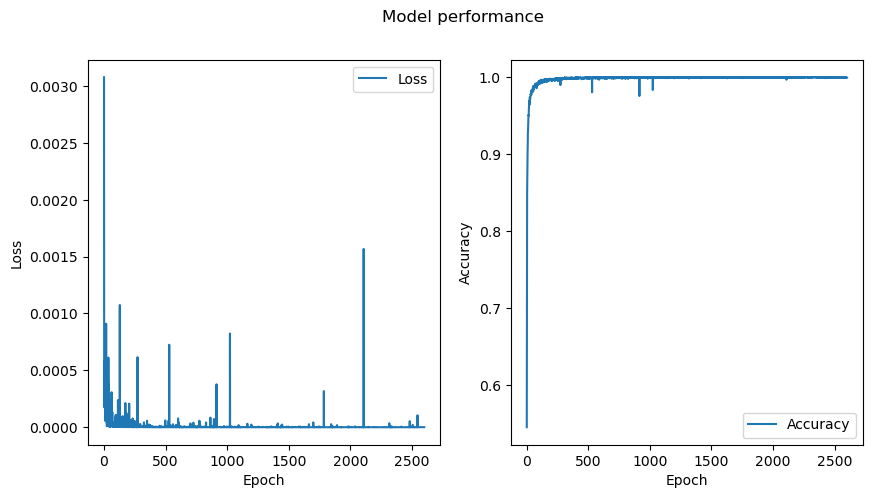

 28%|██▊       | 2800/10000 [2:05:32<5:43:19,  2.86s/it]

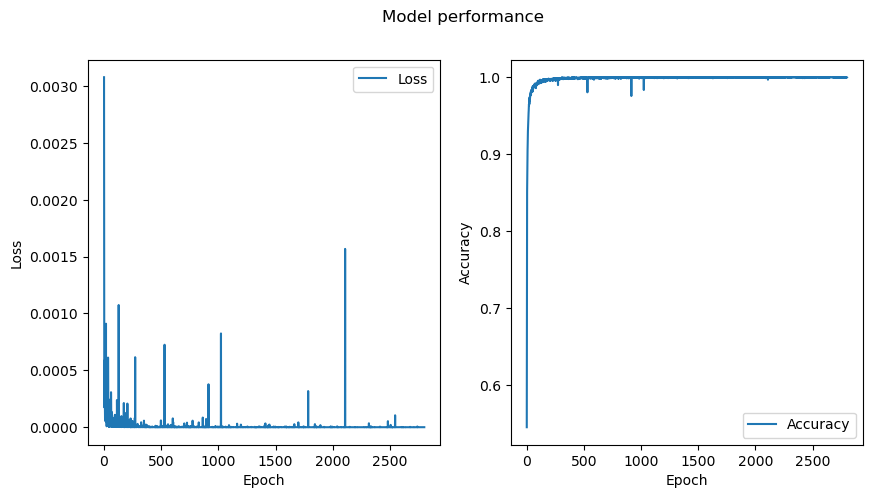

 30%|███       | 3000/10000 [2:15:40<5:34:01,  2.86s/it]

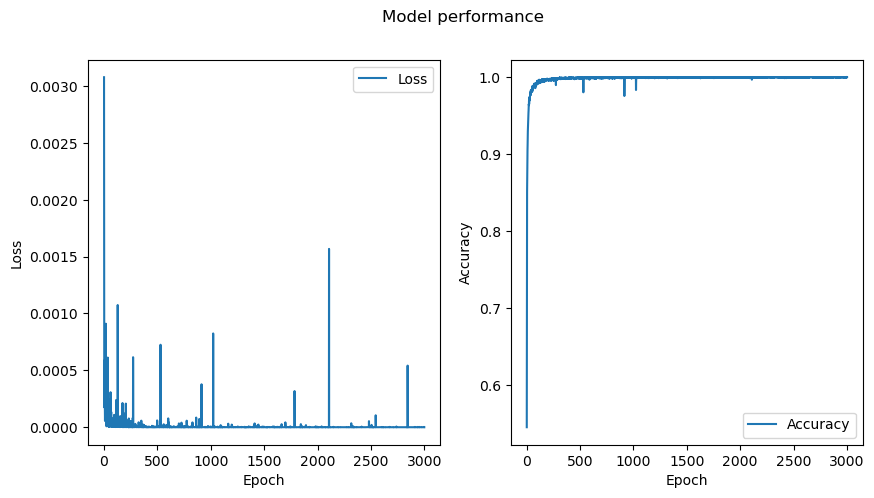

 32%|███▏      | 3200/10000 [2:25:58<6:05:29,  3.22s/it] 

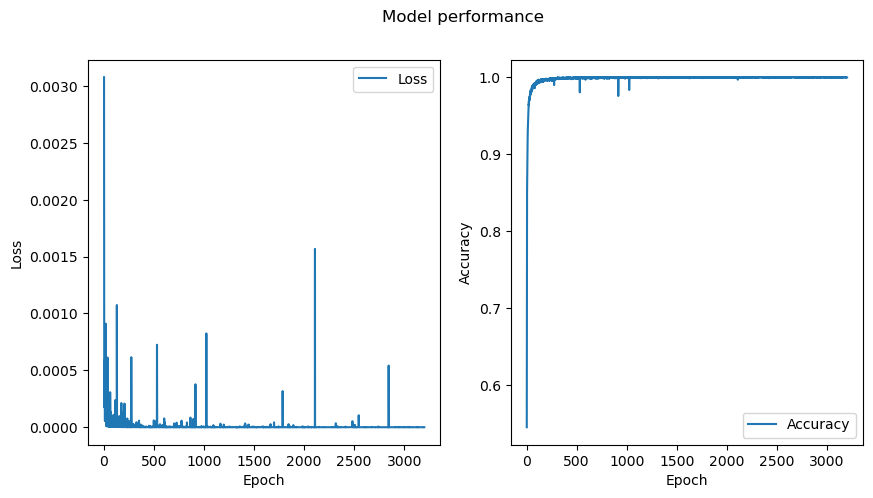

 34%|███▍      | 3400/10000 [2:37:05<3:41:18,  2.01s/it]  

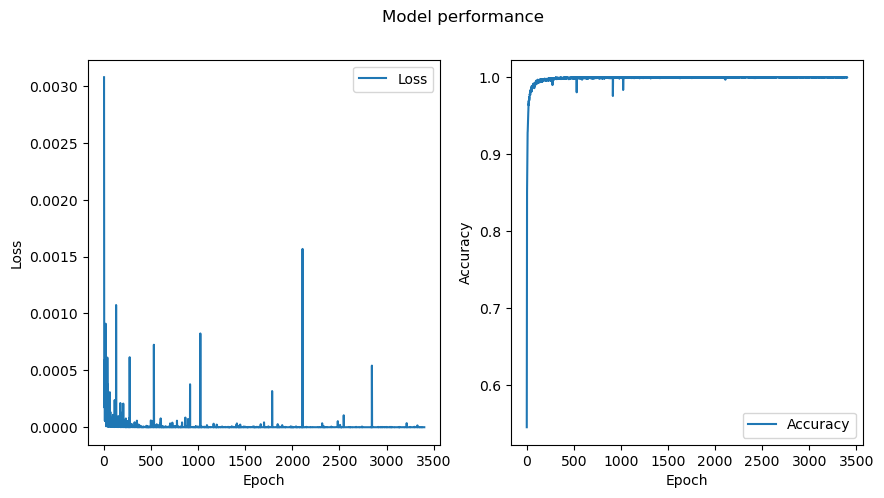

 36%|███▌      | 3600/10000 [2:43:51<3:28:33,  1.96s/it]

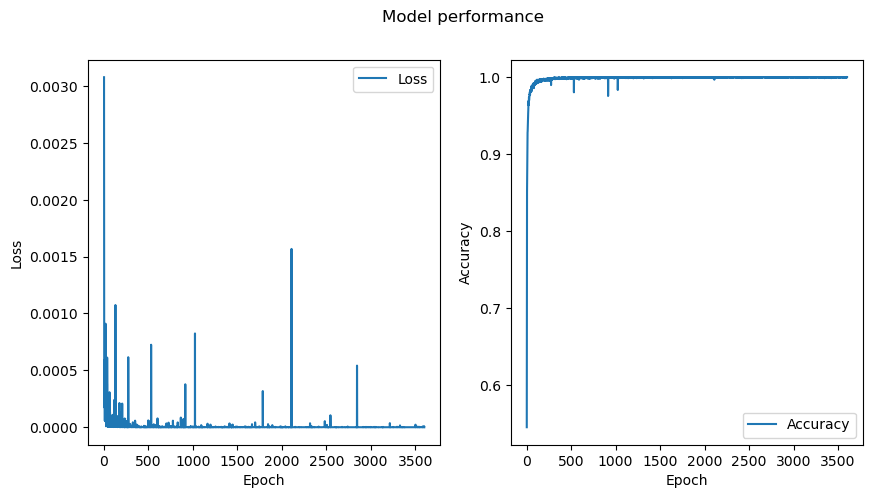

 38%|███▊      | 3800/10000 [2:50:50<3:41:56,  2.15s/it]

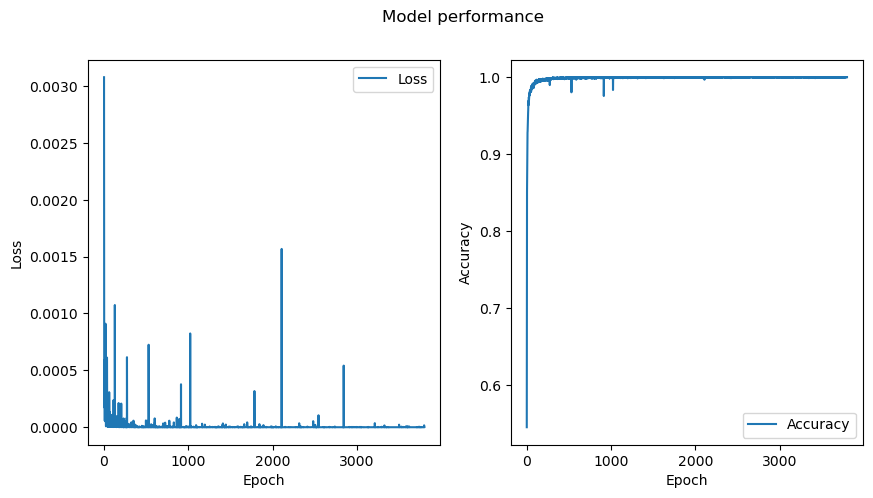

 40%|████      | 4000/10000 [2:57:56<3:25:13,  2.05s/it]

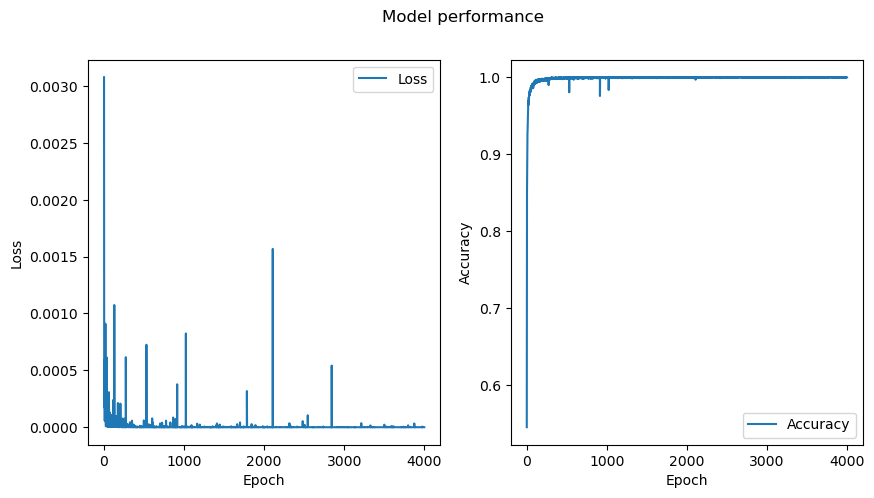

 42%|████▏     | 4200/10000 [3:47:39<3:16:13,  2.03s/it]    

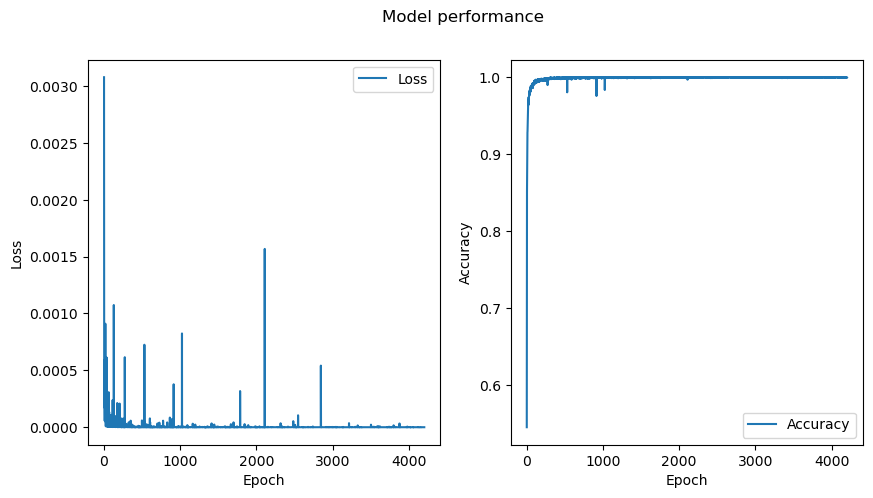

 44%|████▍     | 4400/10000 [3:54:37<3:13:45,  2.08s/it]

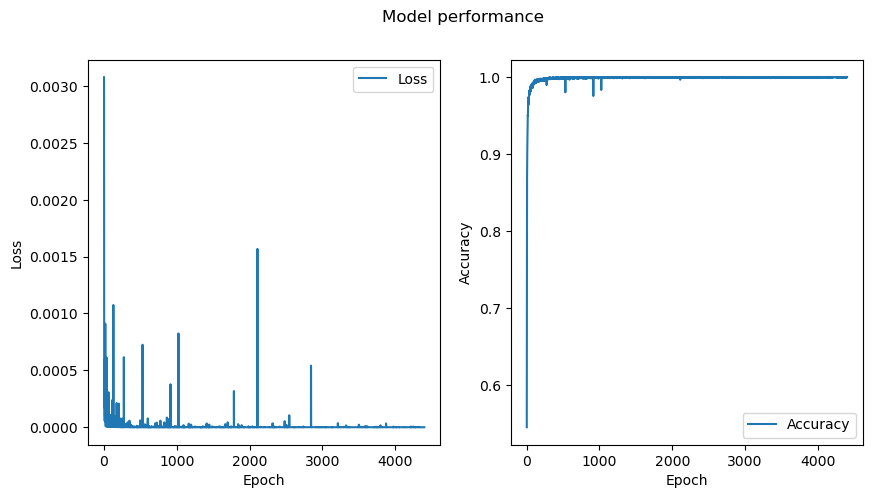

 46%|████▌     | 4600/10000 [4:01:52<3:31:31,  2.35s/it]

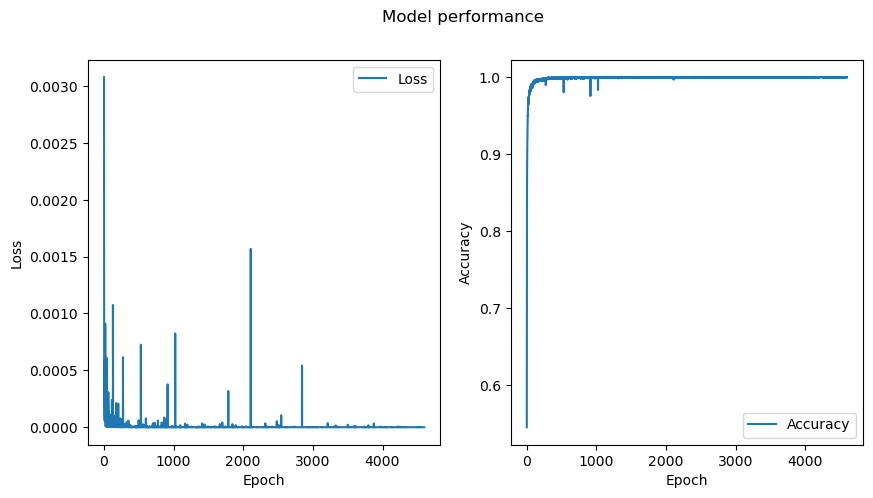

 48%|████▊     | 4800/10000 [4:10:07<3:58:54,  2.76s/it]

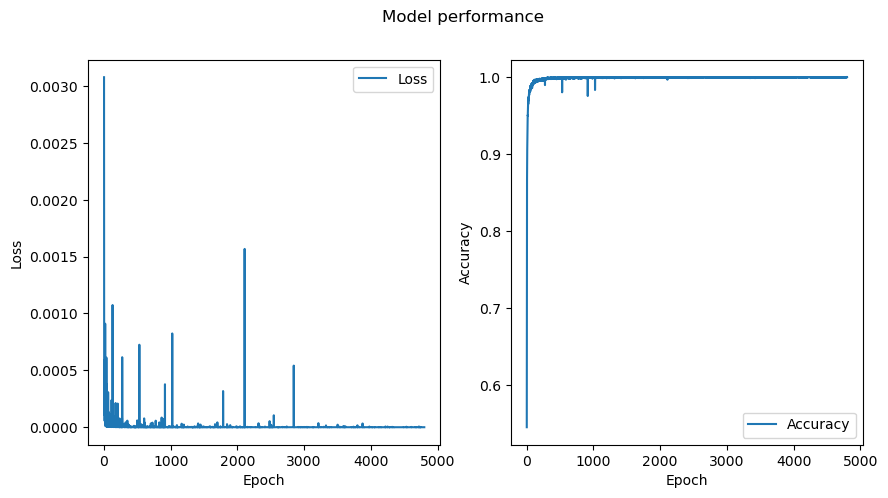

 50%|█████     | 5000/10000 [4:17:22<2:42:57,  1.96s/it]

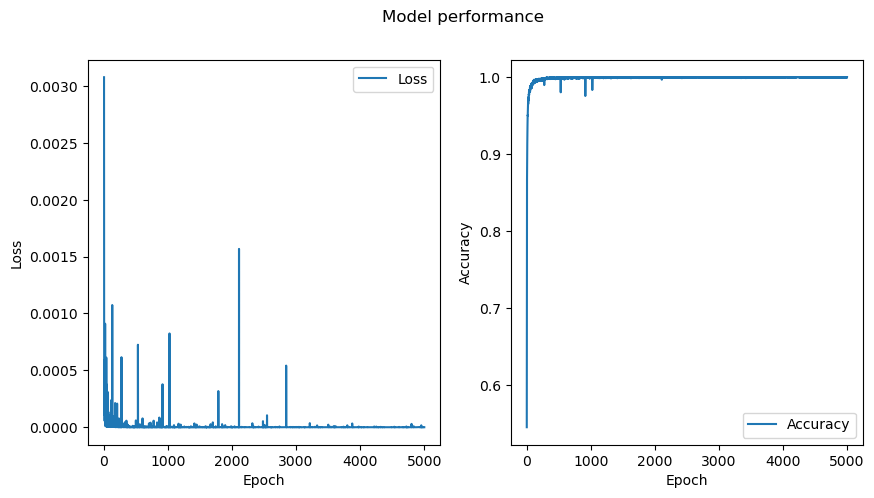

 52%|█████▏    | 5200/10000 [4:24:09<2:33:31,  1.92s/it]

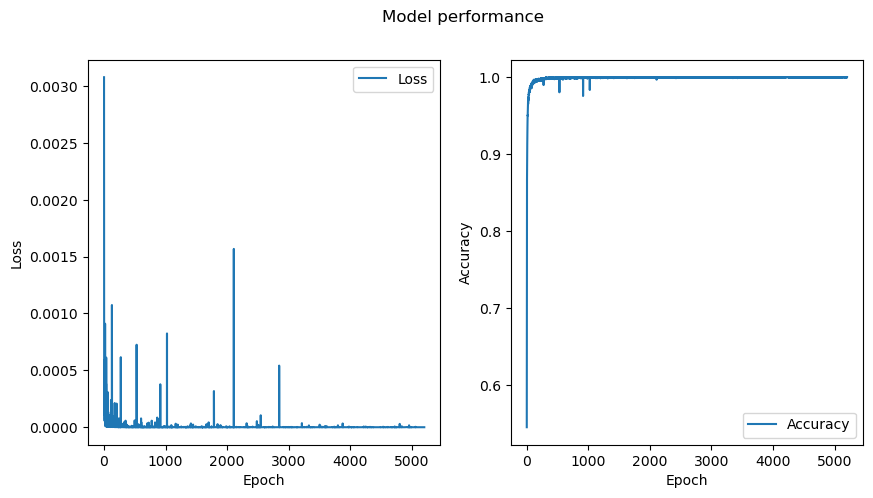

 54%|█████▍    | 5400/10000 [4:32:47<3:38:30,  2.85s/it]

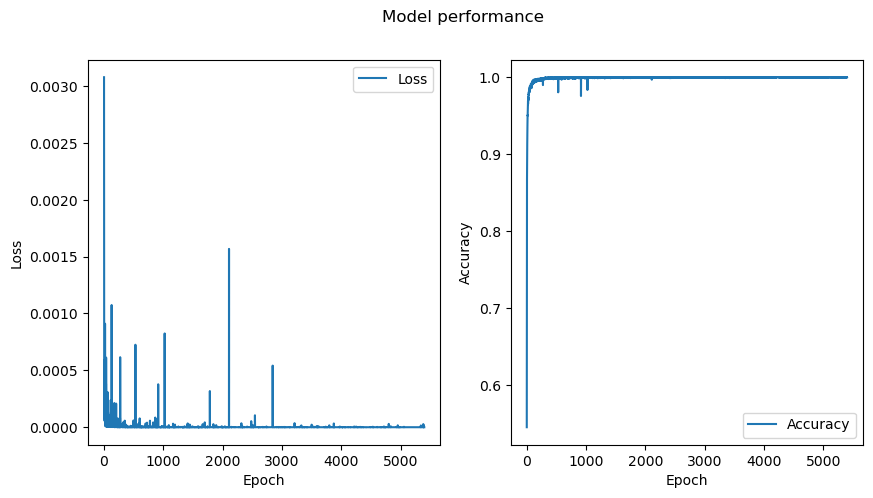

 55%|█████▌    | 5546/10000 [4:38:02<2:19:22,  1.88s/it]

In [ ]:
# Define the probability distribution applied to tasks when they are being selected

# Parameters
n_tasks = 16 # number of tasks created
len_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 3  # Length of the associated integer list for each task. Must be less than len_message
len_message = 8  # Maximum integer value in the associated integer list
#num_samples_list = np.logspace(start=3, stop=5, num=10, base=10, dtype=int) # number of samples created in the dataset
num_samples = 5000 # This is the number of samples created per epoch
samples_per_task = 100
task_sample_freq = 10 # How many epochs between sampling of tasks
# Define hyperparameters
input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.001
batch_size = 32
num_epochs = 10000
num_layers = 8
hidden_size = 256

plot_freq = 200 # How many epoch between creating a plot of progress
#moving_avg = 1 # How the averaging is done in accuracy by task plots. Seems to cause bugs

# Train the model
tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message) # Moved intentionally earlier
print("tasks_dict = ", tasks_dict.items())

# Create instances of the neural network
#model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

# Define loss function and optimizer (same as before)
#criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_list = np.empty(num_epochs)
accuracy_list = np.empty(num_epochs)
accuracy_array = np.zeros((n_tasks, num_epochs//task_sample_freq)) # such that each row is the accuracy for that specific task over all epochs
acc_counter = 0
for epoch in tqdm(range(num_epochs)):
    
    [data, value] = generate_dataset(tasks_dict, num_samples)
    # Create a dataframe for training
    df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])
    
    # Create DataLoaders for the training and test data
    dataset = CustomDataset(df)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    loss = 0.0
    correct = 0
    total = 0
    model.train()

    for inputs, labels in data_loader:
        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels.unsqueeze(1))

        # Compute predictions
        predictions = (outputs >= 0.5).squeeze().long()

        # Compute accuracy
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss += loss.item() * inputs.size(0)

    # Calculate average train loss
    avg_loss = loss / len(dataset)
    # Calculate average train accuracy
    avg_accuracy = correct / total

    # Update the loss list
    loss_list[epoch] = avg_loss
    accuracy_list[epoch] = avg_accuracy
    
    if epoch%task_sample_freq == 0:
        # Find accuracy data
        tasks_list = list(tasks_dict.keys())
        for i in range(n_tasks):
          task_code = tasks_list[i]
          #print(f"task_code = ", task_code)
          [data_per_task, value_per_task] = generate_dataset_for_task(task_code, samples_per_task)
          #print(data_per_task)
          df_per_task = pd.DataFrame(np.concatenate((data_per_task, value_per_task.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])
          #print(df_per_task)
          dataset_per_task = CustomDataset(df_per_task)
          loader_per_task = DataLoader(dataset_per_task, batch_size=batch_size, shuffle=True)
          model.eval()
          task_correct = 0
          task_total = 0
          with torch.no_grad():
            for inputs, labels in loader_per_task:
                outputs = model(inputs)
                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                task_correct += (predictions == labels).sum().item()
                task_total += labels.size(0)
                #print(f'inputs = ', inputs)
                #print(f'labels.size(0) = ', labels.size(0))

                #loss = criterion(outputs, labels.unsqueeze(1)) #if in future I want to calculate loss
                #test_loss += loss.item() * inputs.size(0)
            task_accuracy = task_correct / task_total
            #print(f"task_accuracy = ", task_accuracy)
            accuracy_array[(i, acc_counter)] = task_accuracy
        acc_counter += 1
        
    if epoch % plot_freq == 0 and epoch != 0:
        epoch_plots(epoch, loss_list[:epoch], accuracy_list[:epoch])

epoch_plots(num_epochs, loss_list, accuracy_list)
    
# Display model parameter number. If model is changed, should go into the loop
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters = {pytorch_total_params}")

NameError: name 'loss_list' is not defined

In [ ]:
# Creating the task-based accuracy plot. Now encapsulated in the acc_by_task_plot function.

# Define the moving average window
moving_avg = 10
#eff_num_epochs = num_epochs // task_sample_freq
eff_num_epochs = math.ceil(num_epochs // task_sample_freq) #might be good for off_by_one errors

# Calculate the filtered epochs
epochs = np.arange(0, eff_num_epochs, moving_avg)
filtered_epochs = epochs[:len(epochs)//moving_avg * moving_avg]
scaled_filtered_epochs = [x * task_sample_freq for x in filtered_epochs]
print('epochs = ',epochs)
print('filtered_epochs = ', filtered_epochs)
print('scaled_filtered_epochs = ', scaled_filtered_epochs)
# Create an empty DataFrame
df = pd.DataFrame()

# Loop over the tasks and reshape the accuracy array
for i in range(n_tasks): # THere is strange bug I don't understand when moving_avg is certain values, such as 4
    reshaped_accuracy_array = np.reshape(accuracy_array[i], (-1, moving_avg))
    print('len(np.repeat(filtered_epochs, moving_avg)) = ', len(np.repeat(filtered_epochs, moving_avg)))
    print('len(np.ndarray.flatten(reshaped_accuracy_array)) = ', len(np.ndarray.flatten(reshaped_accuracy_array)))
    # Create a temporary DataFrame for the current task
    temp_df = pd.DataFrame({
        'Epochs': np.repeat(scaled_filtered_epochs, moving_avg),
        'Accuracy': np.ndarray.flatten(reshaped_accuracy_array),
        'Task': i + 1
    })
    
    # Concatenate the temporary DataFrame to the main DataFrame
    df = pd.concat([df, temp_df])
    
# Create a colourbar plot for different tasks, in seaborn. Useful for smoothing stuff out a bit.
# It was getting a bit hard to read with the very high variability.

# Define the color map
color_map = 'coolwarm'  # Change the color map here

# Plotting the data using seaborn
sns.lineplot(data=df, x='Epochs', y='Accuracy', errorbar=('ci', 95), estimator='mean', hue='Task', palette=color_map)

# Add plot labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

sm = plt.cm.ScalarMappable(cmap=color_map)
sm.set_array(range(1, n_tasks + 1))
#plt.colorbar(sm, ticks=np.arange(1, n_tasks + 1, int(n_tasks+1)/10), label='Task Number')
plt.colorbar(sm, ticks=np.linspace(1, n_tasks + 2, n_tasks+1, dtype=int), label='Task Number')

# Remove the legend inside the plot
plt.legend().remove()

# Show the plot
plt.show()

In [10]:
#loss_list_copy = loss_list
#accuracy_list_copy = accuracy_list
#accuracy_array_copy = accuracy_array

In [ ]:
full_loss_list = np.concatenate((loss_list_copy, loss_list), axis=0)
full_accuracy_list = np.concatenate((accuracy_list_copy, accuracy_list), axis=0)
full_accuracy_array = np.concatenate((accuracy_array_copy, accuracy_array), axis=1)

# Making loss and accuracy plots
num_epochs = 20000
epoch_plots(num_epochs, full_loss_list, full_accuracy_list)

# Making task-based plots
# Define the moving average window
moving_avg = 10
#eff_num_epochs = num_epochs // task_sample_freq
eff_num_epochs = math.ceil(num_epochs // task_sample_freq) #might be good for off_by_one errors

# Calculate the filtered epochs
epochs = np.arange(0, eff_num_epochs, moving_avg)
filtered_epochs = epochs[:len(epochs)//moving_avg * moving_avg]
scaled_filtered_epochs = [x * task_sample_freq for x in filtered_epochs]
print('epochs = ',epochs)
print('filtered_epochs = ', filtered_epochs)
print('scaled_filtered_epochs = ', scaled_filtered_epochs)
# Create an empty DataFrame
df = pd.DataFrame()

# Loop over the tasks and reshape the accuracy array
for i in range(n_tasks): # THere is strange bug I don't understand when moving_avg is certain values, such as 4
    reshaped_accuracy_array = np.reshape(full_accuracy_array[i], (-1, moving_avg))
    print('len(np.repeat(filtered_epochs, moving_avg)) = ', len(np.repeat(filtered_epochs, moving_avg)))
    print('len(np.ndarray.flatten(reshaped_accuracy_array)) = ', len(np.ndarray.flatten(reshaped_accuracy_array)))
    # Create a temporary DataFrame for the current task
    temp_df = pd.DataFrame({
        'Epochs': np.repeat(scaled_filtered_epochs, moving_avg),
        'Accuracy': np.ndarray.flatten(reshaped_accuracy_array),
        'Task': i + 1
    })
    
    # Concatenate the temporary DataFrame to the main DataFrame
    df = pd.concat([df, temp_df])
    
# Create a colourbar plot for different tasks, in seaborn. Useful for smoothing stuff out a bit.
# It was getting a bit hard to read with the very high variability.

# Define the color map
color_map = 'coolwarm'  # Change the color map here

# Plotting the data using seaborn
sns.lineplot(data=df, x='Epochs', y='Accuracy', errorbar=('ci', 95), estimator='mean', hue='Task', palette=color_map)

# Add plot labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

sm = plt.cm.ScalarMappable(cmap=color_map)
sm.set_array(range(1, n_tasks + 1))
#plt.colorbar(sm, ticks=np.arange(1, n_tasks + 1, int(n_tasks+1)/10), label='Task Number')
plt.colorbar(sm, ticks=np.linspace(1, n_tasks + 2, n_tasks+1, dtype=int), label='Task Number')

# Remove the legend inside the plot
plt.legend().remove()

# Show the plot
plt.show()

# Below this point is a transfer learning test

tasks_dict =  dict_items([('10000001', [5, 6, 7]), ('00100011', [0, 1, 5]), ('10100011', [4, 5, 7]), ('10101110', [2, 4, 6]), ('11000110', [7, 4, 2]), ('10001100', [4, 6, 7]), ('11000011', [4, 2, 3]), ('01111010', [4, 1, 7]), ('10101101', [2, 3, 7]), ('01010000', [5, 3, 2]), ('10111011', [6, 4, 3]), ('00100111', [6, 5, 2]), ('00000100', [4, 3, 5]), ('00001110', [6, 5, 4]), ('10010101', [4, 6, 5]), ('10111001', [3, 5, 0])])


  7%|▋         | 500/7000 [21:16<5:03:33,  2.80s/it] 

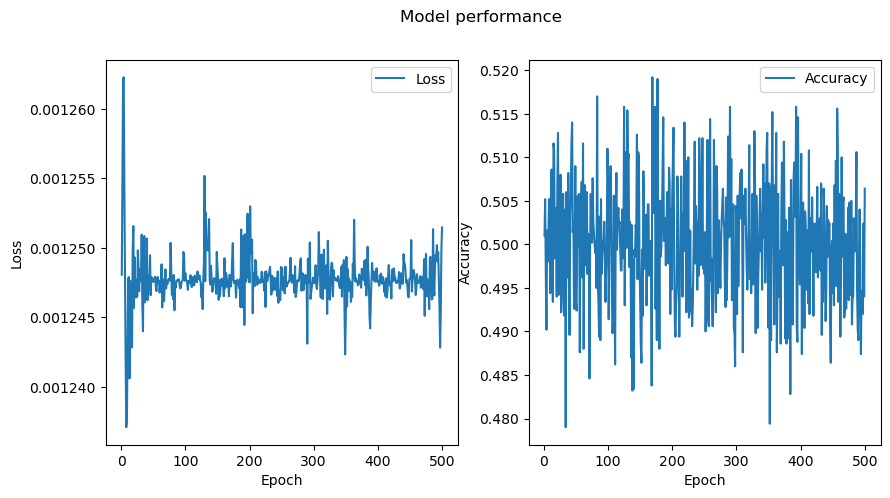

 14%|█▍        | 1000/7000 [52:30<3:41:54,  2.22s/it]  

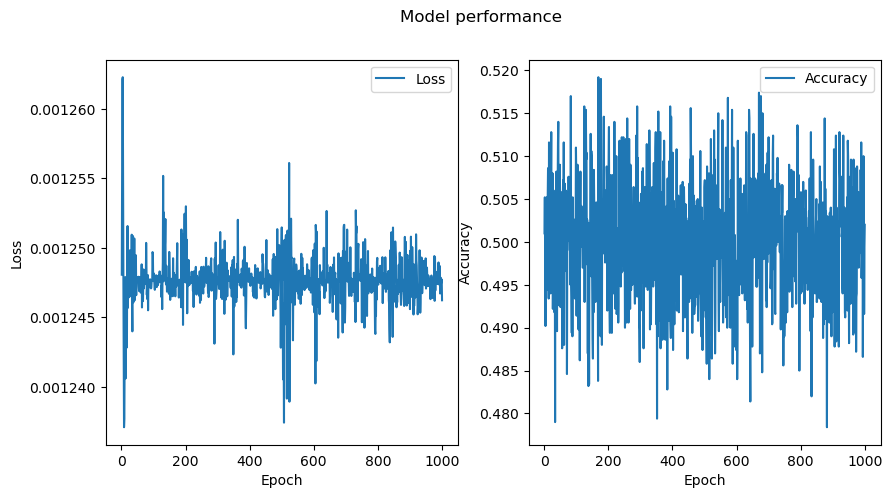

 21%|██▏       | 1500/7000 [1:14:43<3:20:26,  2.19s/it]

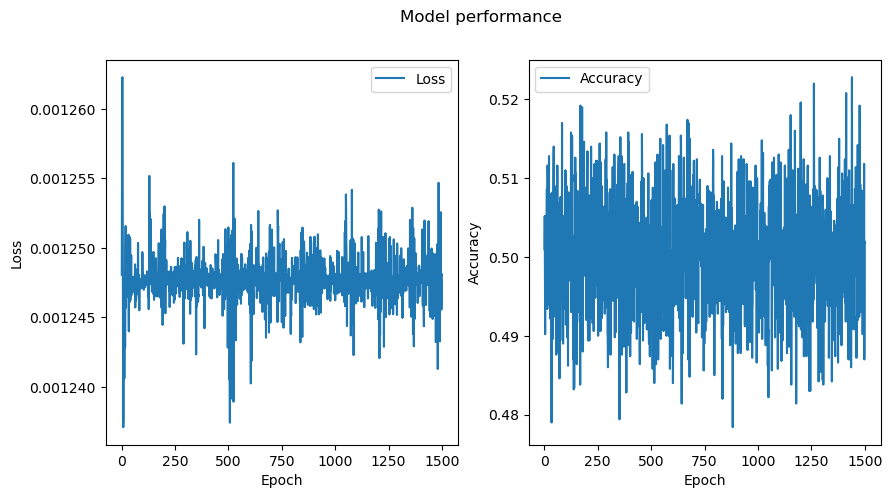

 29%|██▊       | 2000/7000 [1:38:44<3:01:07,  2.17s/it] 

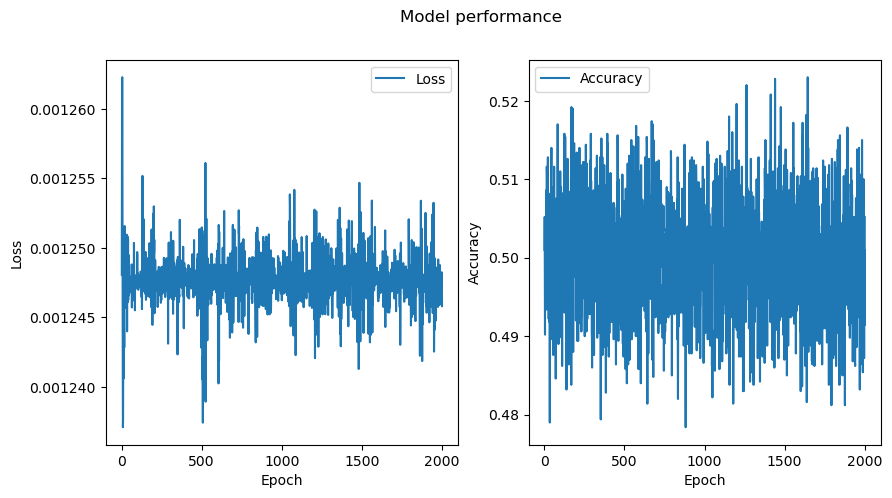

 36%|███▌      | 2500/7000 [2:00:49<2:42:41,  2.17s/it]

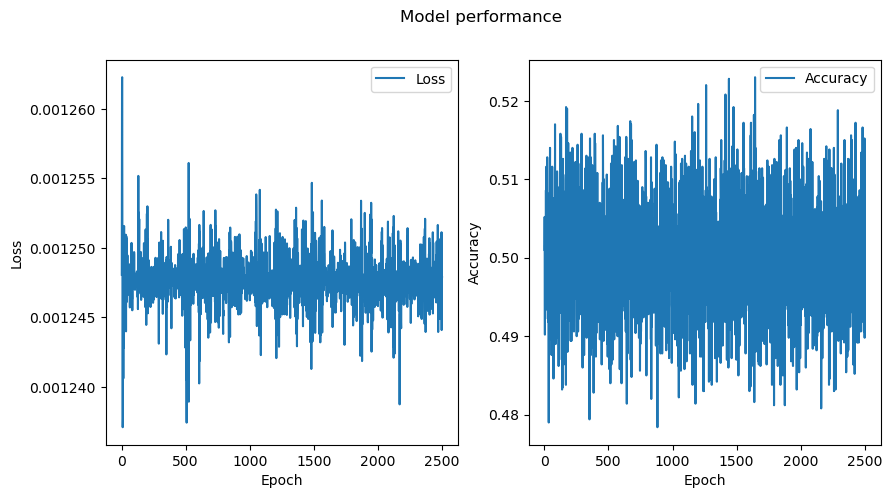

 43%|████▎     | 3000/7000 [2:25:11<3:16:32,  2.95s/it]

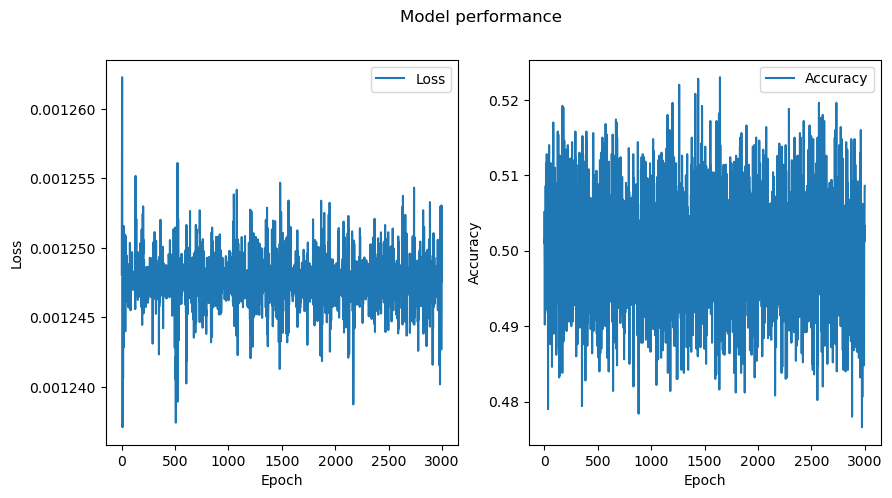

 50%|█████     | 3500/7000 [3:42:51<2:44:00,  2.81s/it]    

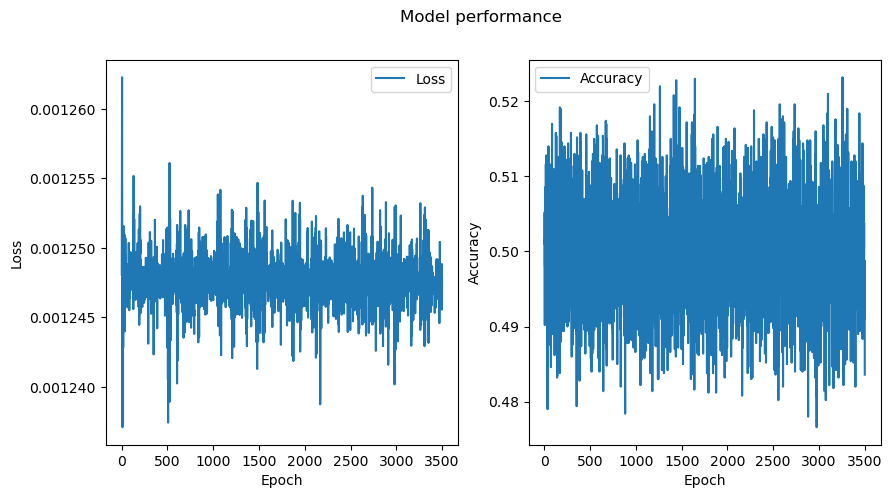

 57%|█████▋    | 4000/7000 [4:07:00<2:19:29,  2.79s/it]

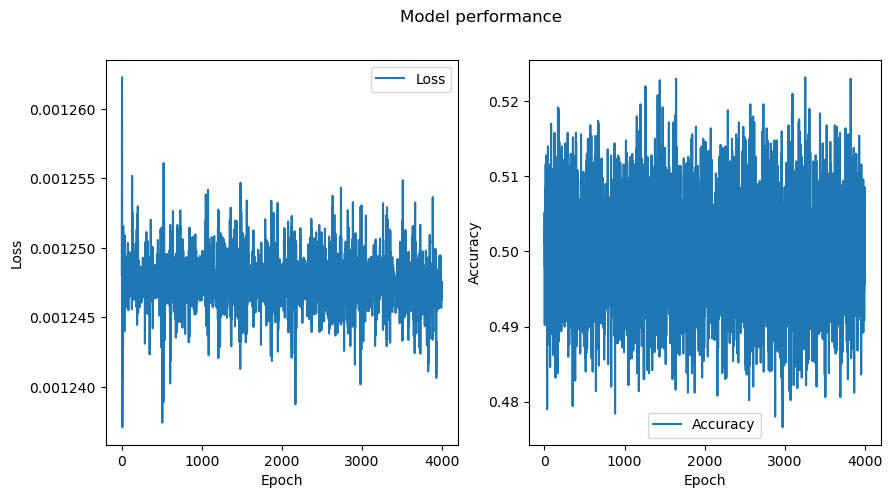

 64%|██████▍   | 4500/7000 [4:31:30<1:54:42,  2.75s/it]

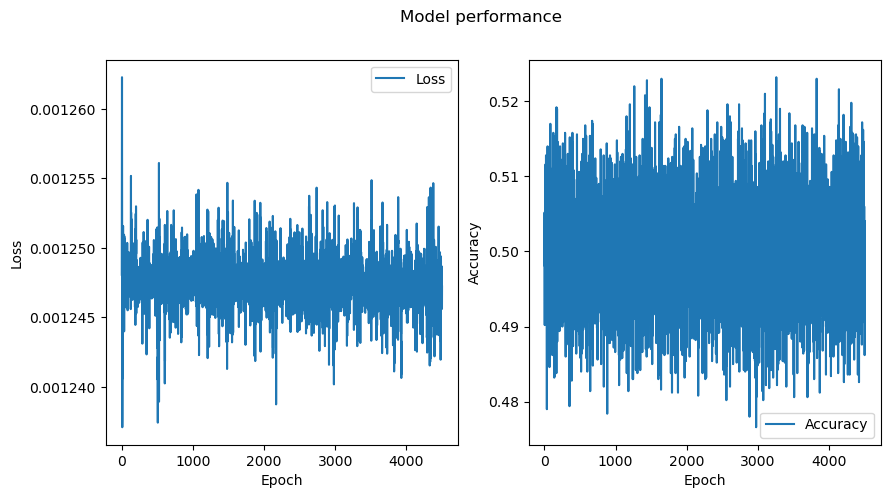

 71%|███████▏  | 5000/7000 [4:55:39<1:35:54,  2.88s/it]

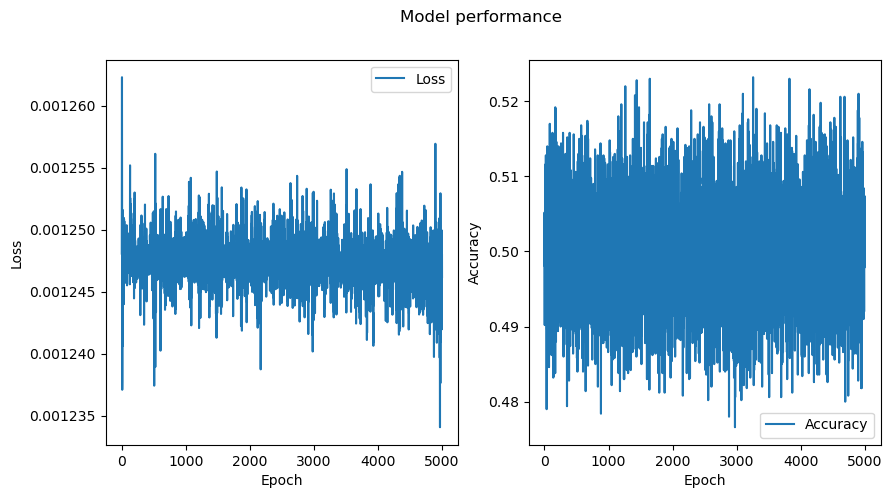

 79%|███████▊  | 5500/7000 [5:20:00<1:03:34,  2.54s/it]

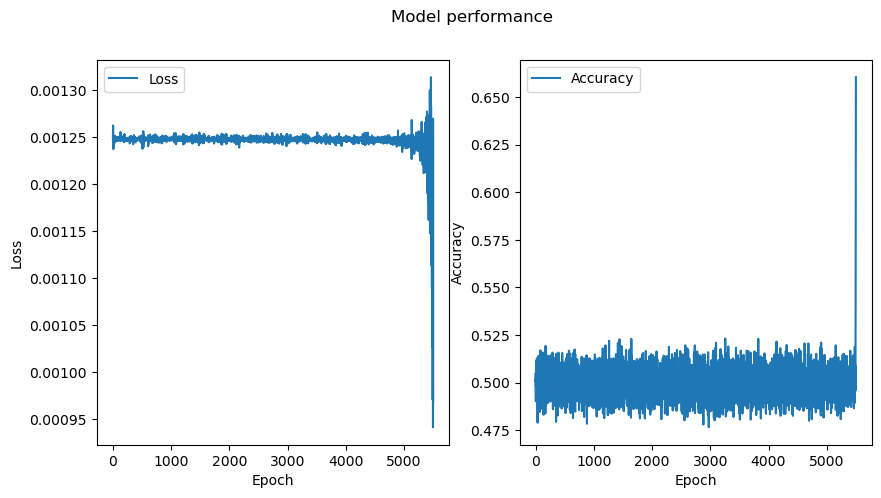

 86%|████████▌ | 6000/7000 [5:41:38<38:10,  2.29s/it]  

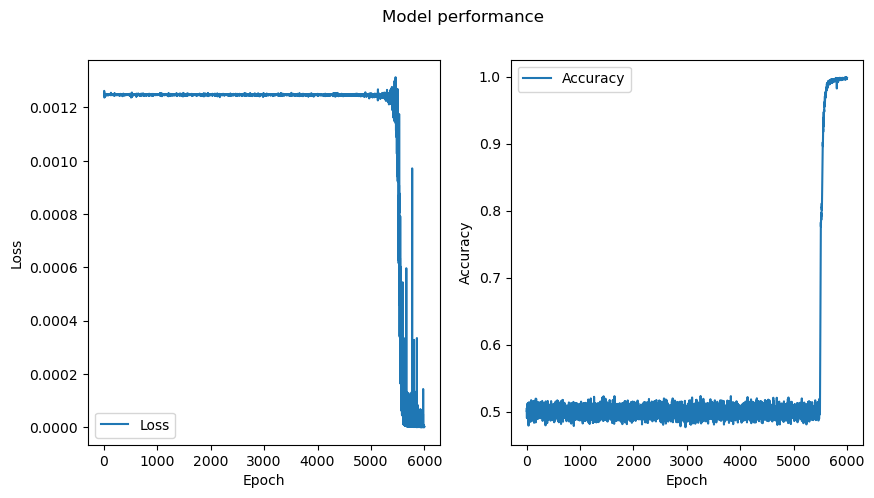

 93%|█████████▎| 6500/7000 [6:27:08<19:03,  2.29s/it]    

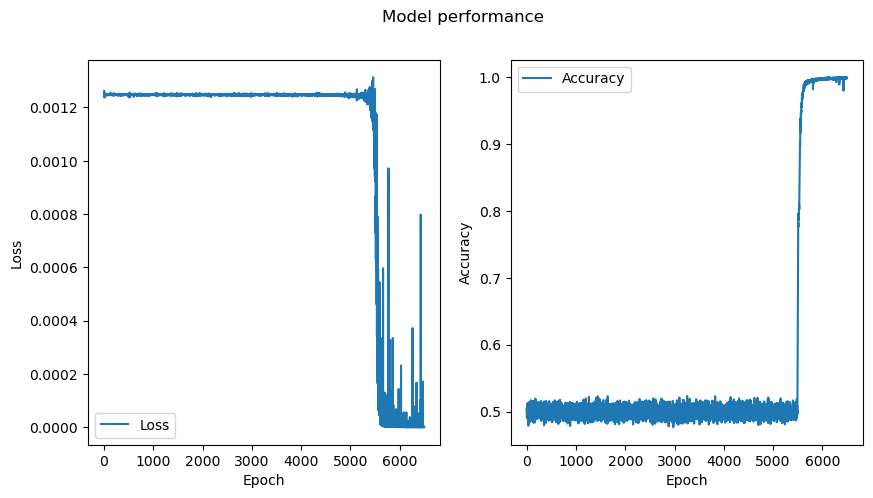

100%|██████████| 7000/7000 [6:49:39<00:00,  3.51s/it]


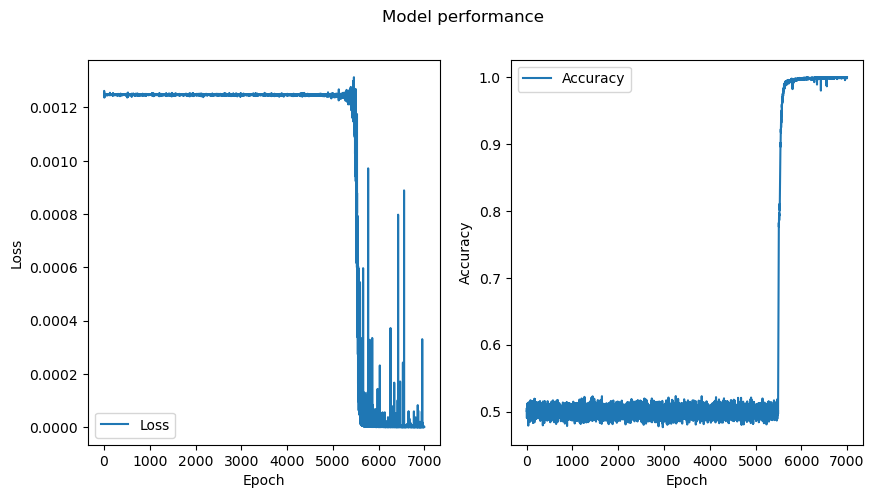

Total model parameters = 399361


In [6]:
# Define the probability distribution applied to tasks when they are being selected

# Parameters
n_tasks = 16 # number of tasks created
len_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 3  # Length of the associated integer list for each task. Must be less than len_message
len_message = 8  # Maximum integer value in the associated integer list
#num_samples_list = np.logspace(start=3, stop=5, num=10, base=10, dtype=int) # number of samples created in the dataset
num_samples = 5000 # This is the number of samples created per epoch
samples_per_task = 200
task_sample_freq = 10 # How many epochs between sampling of tasks
# Define hyperparameters
input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.001
batch_size = 32
num_epochs = 7000 # To be halted post grok
num_layers = 8
hidden_size = 256

plot_freq = 500 # How many epoch between creating a plot of progress
#moving_avg = 1 # How the averaging is done in accuracy by task plots. Seems to cause bugs

# Train the model
tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message) # Moved intentionally earlier
print("tasks_dict = ", tasks_dict.items())

# Create instances of the neural network
model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

# Define loss function and optimizer (same as before)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_list = np.empty(num_epochs)
accuracy_list = np.empty(num_epochs)
accuracy_array = np.zeros((n_tasks, num_epochs//task_sample_freq)) # such that each row is the accuracy for that specific task over all epochs
acc_counter = 0
for epoch in tqdm(range(num_epochs)):
    
    [data, value] = generate_dataset(tasks_dict, num_samples)
    # Create a dataframe for training
    df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])
    
    # Create DataLoaders for the training and test data
    dataset = CustomDataset(df)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    loss = 0.0
    correct = 0
    total = 0
    model.train()

    for inputs, labels in data_loader:
        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels.unsqueeze(1))

        # Compute predictions
        predictions = (outputs >= 0.5).squeeze().long()

        # Compute accuracy
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss += loss.item() * inputs.size(0)

    # Calculate average train loss
    avg_loss = loss / len(dataset)
    # Calculate average train accuracy
    avg_accuracy = correct / total

    # Update the loss list
    loss_list[epoch] = avg_loss
    accuracy_list[epoch] = avg_accuracy
    
    if epoch%task_sample_freq == 0:
        # Find accuracy data
        tasks_list = list(tasks_dict.keys())
        for i in range(n_tasks):
          task_code = tasks_list[i]
          #print(f"task_code = ", task_code)
          [data_per_task, value_per_task] = generate_dataset_for_task(task_code, samples_per_task)
          #print(data_per_task)
          df_per_task = pd.DataFrame(np.concatenate((data_per_task, value_per_task.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])
          #print(df_per_task)
          dataset_per_task = CustomDataset(df_per_task)
          loader_per_task = DataLoader(dataset_per_task, batch_size=batch_size, shuffle=True)
          model.eval()
          task_correct = 0
          task_total = 0
          with torch.no_grad():
            for inputs, labels in loader_per_task:
                outputs = model(inputs)
                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                task_correct += (predictions == labels).sum().item()
                task_total += labels.size(0)
                #print(f'inputs = ', inputs)
                #print(f'labels.size(0) = ', labels.size(0))

                #loss = criterion(outputs, labels.unsqueeze(1)) #if in future I want to calculate loss
                #test_loss += loss.item() * inputs.size(0)
            task_accuracy = task_correct / task_total
            #print(f"task_accuracy = ", task_accuracy)
            accuracy_array[(i, acc_counter)] = task_accuracy
        acc_counter += 1
        
    if epoch % plot_freq == 0 and epoch != 0:
        epoch_plots(epoch, loss_list[:epoch], accuracy_list[:epoch])

epoch_plots(num_epochs, loss_list, accuracy_list)
    
# Display model parameter number. If model is changed, should go into the loop
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters = {pytorch_total_params}")

In [7]:
# Make copies of this earlier run. Used for altering plots later on.

loss_list_copy = loss_list
accuracy_list_copy = accuracy_list
accuracy_array_copy = accuracy_array

epochs =  [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690]
filtered_epochs =  [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690]
scaled_filtered_epochs =  [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 64

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\AppData\Local\Temp\ipykernel_13356\490225290.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(1, n_tasks + 2, n_tasks+1, dtype=int), label='Task Number')


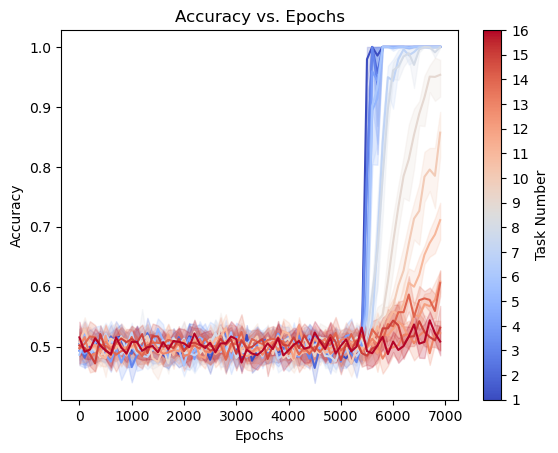

In [8]:
# Creating the task-based accuracy plot. Now encapsulated in the acc_by_task_plot function.
#num_epochs = 10000 # change this to whenever the above run was stopped
# Define the moving average window
moving_avg = 10
#eff_num_epochs = num_epochs // task_sample_freq
eff_num_epochs = math.ceil(num_epochs // task_sample_freq) #might be good for off_by_one errors

# Calculate the filtered epochs
epochs = np.arange(0, eff_num_epochs, moving_avg)
filtered_epochs = epochs[:len(epochs)//moving_avg * moving_avg]
scaled_filtered_epochs = [x * task_sample_freq for x in filtered_epochs]
print('epochs = ',epochs)
print('filtered_epochs = ', filtered_epochs)
print('scaled_filtered_epochs = ', scaled_filtered_epochs)
# Create an empty DataFrame
df = pd.DataFrame()

# Loop over the tasks and reshape the accuracy array
for i in range(n_tasks): # THere is strange bug I don't understand when moving_avg is certain values, such as 4
    reshaped_accuracy_array = np.reshape(accuracy_array[i], (-1, moving_avg))
    print('len(np.repeat(filtered_epochs, moving_avg)) = ', len(np.repeat(filtered_epochs, moving_avg)))
    print('len(np.ndarray.flatten(reshaped_accuracy_array)) = ', len(np.ndarray.flatten(reshaped_accuracy_array)))
    # Create a temporary DataFrame for the current task
    temp_df = pd.DataFrame({
        'Epochs': np.repeat(scaled_filtered_epochs, moving_avg),
        'Accuracy': np.ndarray.flatten(reshaped_accuracy_array),
        'Task': i + 1
    })
    
    # Concatenate the temporary DataFrame to the main DataFrame
    df = pd.concat([df, temp_df])
    
# Create a colourbar plot for different tasks, in seaborn. Useful for smoothing stuff out a bit.
# It was getting a bit hard to read with the very high variability.

# Define the color map
color_map = 'coolwarm'  # Change the color map here

# Plotting the data using seaborn
sns.lineplot(data=df, x='Epochs', y='Accuracy', errorbar=('ci', 95), estimator='mean', hue='Task', palette=color_map)

# Add plot labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

sm = plt.cm.ScalarMappable(cmap=color_map)
sm.set_array(range(1, n_tasks + 1))
#plt.colorbar(sm, ticks=np.arange(1, n_tasks + 1, int(n_tasks+1)/10), label='Task Number')
plt.colorbar(sm, ticks=np.linspace(1, n_tasks + 2, n_tasks+1, dtype=int), label='Task Number')

# Remove the legend inside the plot
plt.legend().remove()

# Show the plot
plt.show()

tasks_dict =  dict_items([('11010110', [6, 5, 0]), ('00011010', [5, 3, 4]), ('00101100', [1, 3, 6]), ('00001101', [5, 1, 2]), ('10010100', [4, 7, 5]), ('10111111', [6, 3, 2]), ('11001001', [1, 4, 6]), ('01101001', [5, 4, 7]), ('01110101', [1, 2, 4]), ('01000110', [2, 5, 0]), ('01011010', [6, 0, 2]), ('11011101', [0, 5, 1]), ('11000010', [6, 0, 4]), ('11100011', [3, 2, 5]), ('11010101', [6, 4, 0]), ('01111111', [6, 7, 0])])


 10%|█         | 1000/10000 [43:21<6:27:18,  2.58s/it]

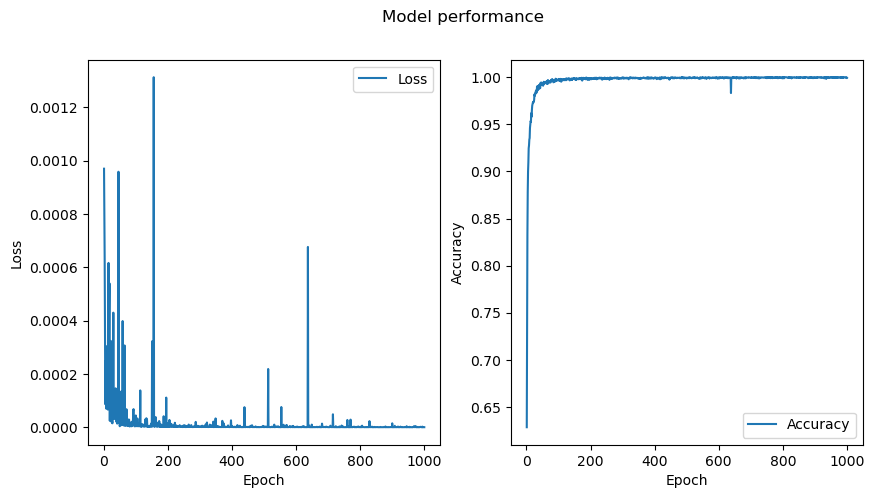

 20%|██        | 2000/10000 [1:27:01<5:44:13,  2.58s/it]

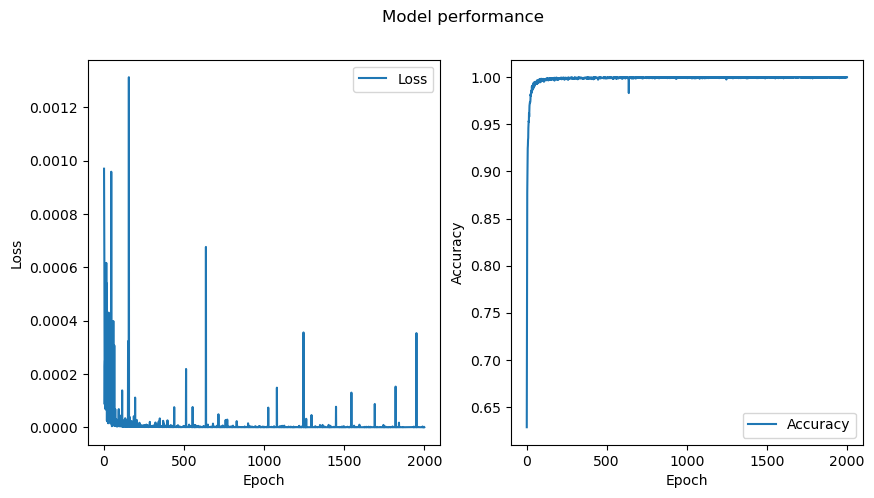

 30%|███       | 3000/10000 [2:10:11<5:08:45,  2.65s/it]

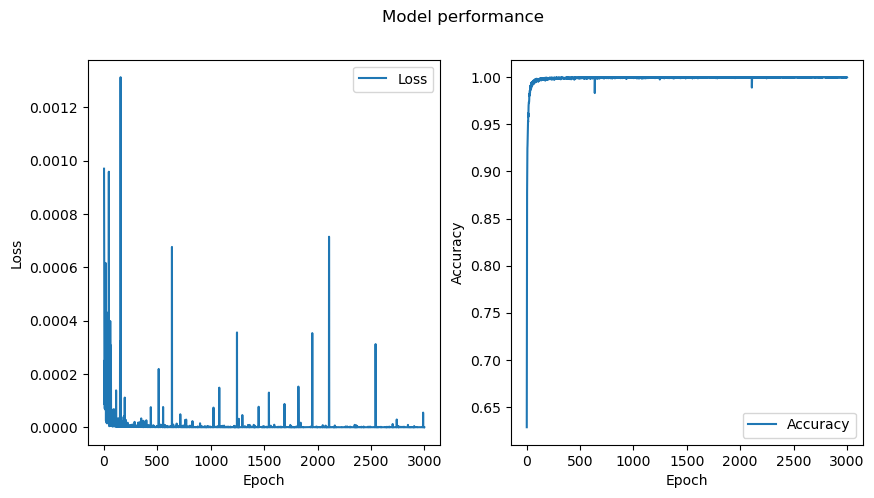

 40%|████      | 4000/10000 [2:53:18<4:05:20,  2.45s/it]

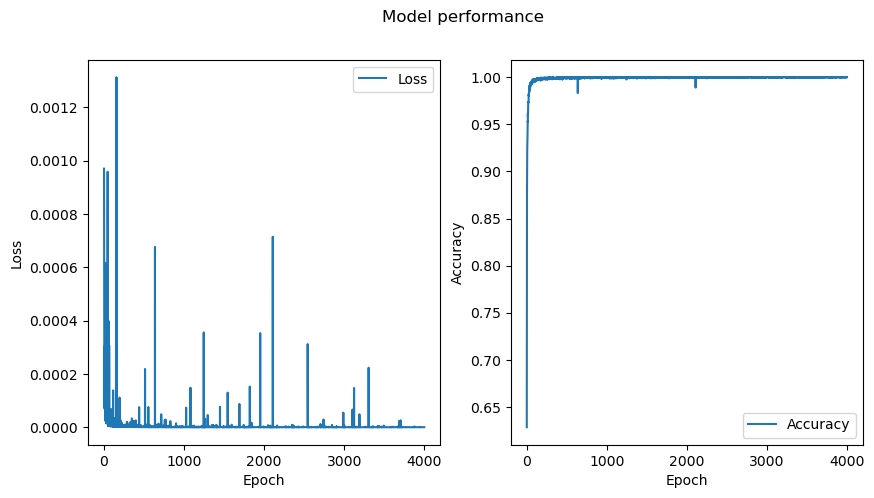

 50%|█████     | 5000/10000 [3:36:07<3:30:52,  2.53s/it]

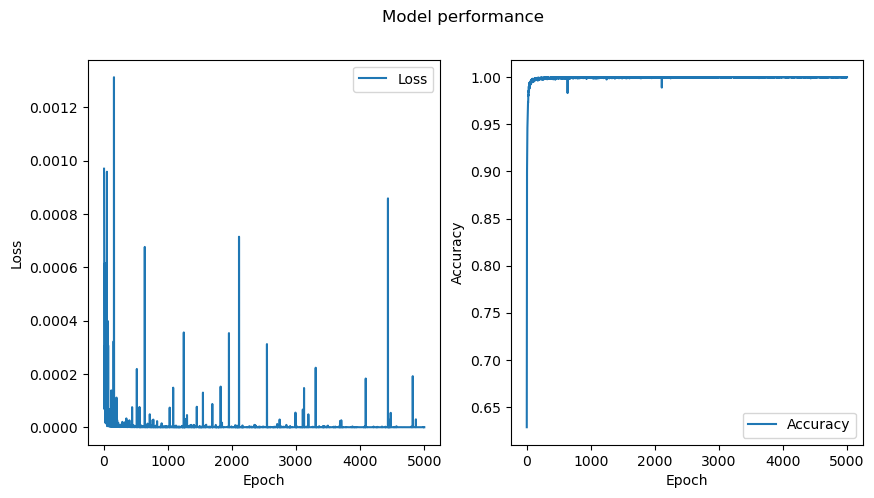

 60%|██████    | 6000/10000 [4:19:06<2:53:21,  2.60s/it]

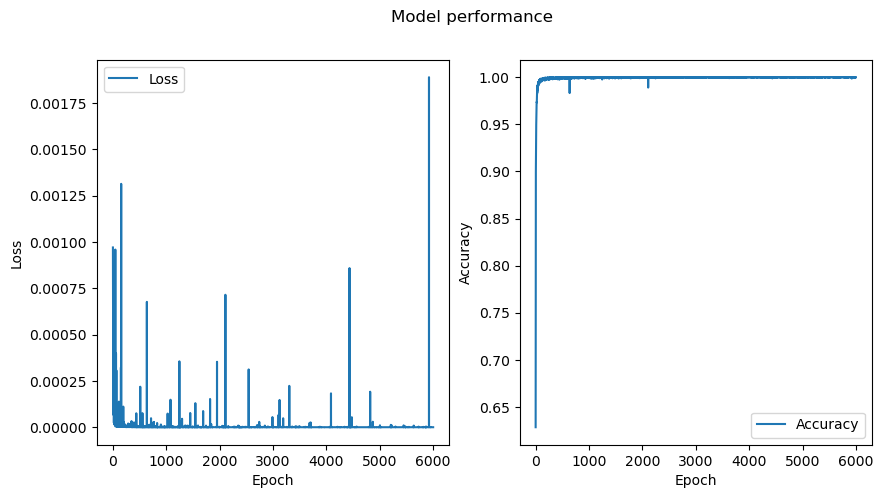

 70%|███████   | 7000/10000 [5:02:40<2:34:47,  3.10s/it]

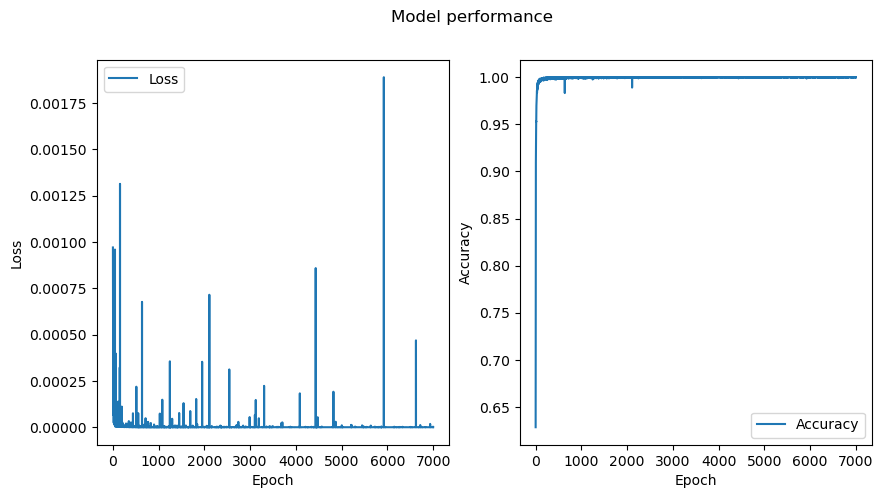

 80%|████████  | 8000/10000 [5:46:20<1:27:32,  2.63s/it]

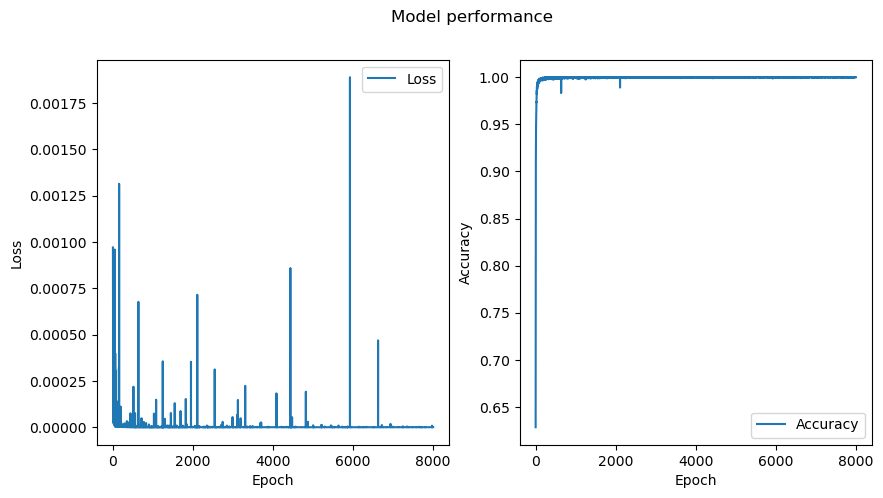

 90%|█████████ | 9000/10000 [6:29:12<43:48,  2.63s/it]  

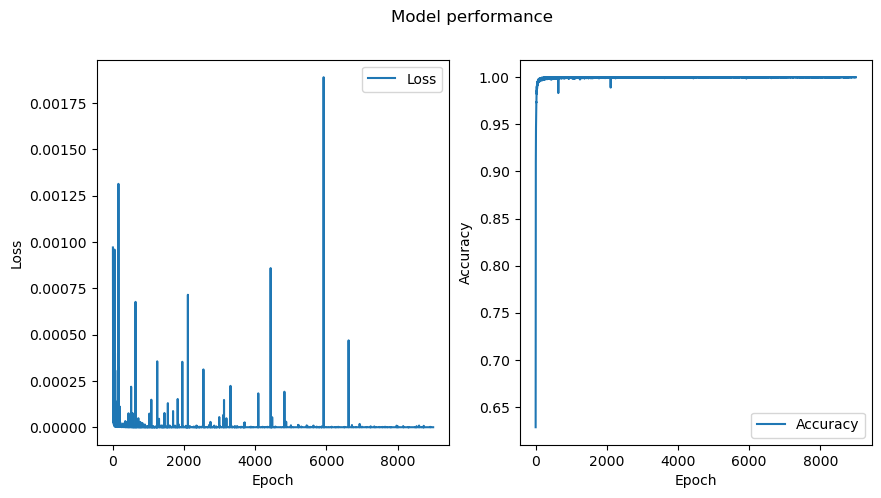

100%|██████████| 10000/10000 [7:12:15<00:00,  2.59s/it]


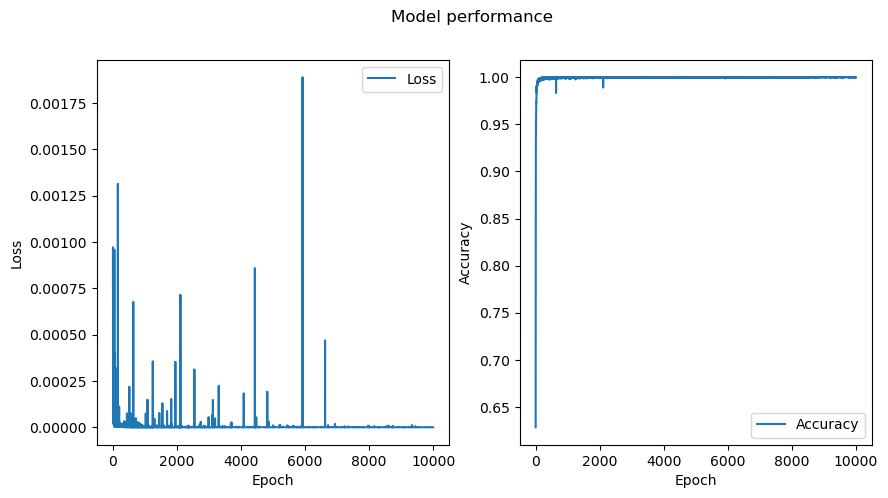

Total model parameters = 399361
epochs =  [   0   10   20   30   40   50   60   70   80   90  100  110  120  130
  140  150  160  170  180  190  200  210  220  230  240  250  260  270
  280  290  300  310  320  330  340  350  360  370  380  390  400  410
  420  430  440  450  460  470  480  490  500  510  520  530  540  550
  560  570  580  590  600  610  620  630  640  650  660  670  680  690
  700  710  720  730  740  750  760  770  780  790  800  810  820  830
  840  850  860  870  880  890  900  910  920  930  940  950  960  970
  980  990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110
 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250
 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390
 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530
 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670
 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810
 1820 1830 1840 1850 1860 1870 1880

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\AppData\Local\Temp\ipykernel_13356\2240371117.py:174: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(1, n_tasks + 2, n_tasks+1, dtype=int), label='Task Number')


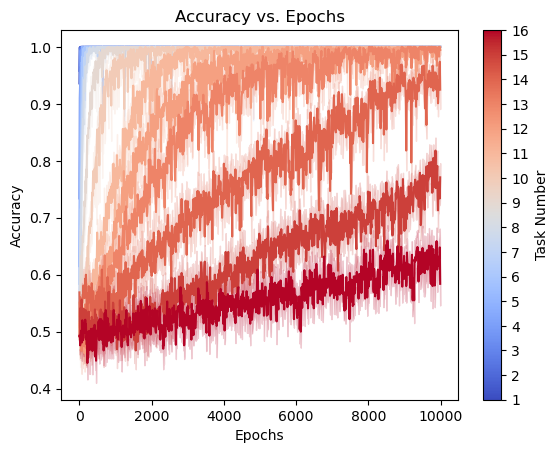

In [12]:
# This code reuses the model above. It creates a new task dictionary however

# Parameters
n_tasks = 16 # number of tasks created
len_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 3  # Length of the associated integer list for each task. Must be less than len_message
len_message = 8  # Maximum integer value in the associated integer list
#num_samples_list = np.logspace(start=3, stop=5, num=10, base=10, dtype=int) # number of samples created in the dataset
num_samples = 5000 # This is the number of samples created per epoch
samples_per_task = 100
task_sample_freq = 1 # How many epochs between sampling of tasks
# Define hyperparameters
input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.001
batch_size = 32
num_epochs = 10000 # To be halted post grok
num_layers = 8
hidden_size = 256

plot_freq = 1000 # How many epoch between creating a plot of progress
#moving_avg = 1 # How the averaging is done in accuracy by task plots. Seems to cause bugs

# Train the model
tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message) # Moved intentionally earlier
print("tasks_dict = ", tasks_dict.items())

# Create instances of the neural network
#model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

# Define loss function and optimizer (same as before)
#criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_list = np.empty(num_epochs)
accuracy_list = np.empty(num_epochs)
accuracy_array = np.zeros((n_tasks, num_epochs//task_sample_freq)) # such that each row is the accuracy for that specific task over all epochs
acc_counter = 0
for epoch in tqdm(range(num_epochs)):
    
    [data, value] = generate_dataset(tasks_dict, num_samples)
    # Create a dataframe for training
    df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])
    
    # Create DataLoaders for the training and test data
    dataset = CustomDataset(df)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    loss = 0.0
    correct = 0
    total = 0
    model.train()

    for inputs, labels in data_loader:
        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels.unsqueeze(1))

        # Compute predictions
        predictions = (outputs >= 0.5).squeeze().long()

        # Compute accuracy
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss += loss.item() * inputs.size(0)

    # Calculate average train loss
    avg_loss = loss / len(dataset)
    # Calculate average train accuracy
    avg_accuracy = correct / total

    # Update the loss list
    loss_list[epoch] = avg_loss
    accuracy_list[epoch] = avg_accuracy
    
    if epoch%task_sample_freq == 0:
        # Find accuracy data
        tasks_list = list(tasks_dict.keys())
        for i in range(n_tasks):
          task_code = tasks_list[i]
          #print(f"task_code = ", task_code)
          [data_per_task, value_per_task] = generate_dataset_for_task(task_code, samples_per_task)
          #print(data_per_task)
          df_per_task = pd.DataFrame(np.concatenate((data_per_task, value_per_task.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])
          #print(df_per_task)
          dataset_per_task = CustomDataset(df_per_task)
          loader_per_task = DataLoader(dataset_per_task, batch_size=batch_size, shuffle=True)
          model.eval()
          task_correct = 0
          task_total = 0
          with torch.no_grad():
            for inputs, labels in loader_per_task:
                outputs = model(inputs)
                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                task_correct += (predictions == labels).sum().item()
                task_total += labels.size(0)
                #print(f'inputs = ', inputs)
                #print(f'labels.size(0) = ', labels.size(0))

                #loss = criterion(outputs, labels.unsqueeze(1)) #if in future I want to calculate loss
                #test_loss += loss.item() * inputs.size(0)
            task_accuracy = task_correct / task_total
            #print(f"task_accuracy = ", task_accuracy)
            accuracy_array[(i, acc_counter)] = task_accuracy
        acc_counter += 1
        
    if epoch % plot_freq == 0 and epoch != 0:
        epoch_plots(epoch, loss_list[:epoch], accuracy_list[:epoch])

epoch_plots(num_epochs, loss_list, accuracy_list)
    
# Display model parameter number. If model is changed, should go into the loop
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters = {pytorch_total_params}")

# Define the moving average window
moving_avg = 10
#eff_num_epochs = num_epochs // task_sample_freq
eff_num_epochs = math.ceil(num_epochs // task_sample_freq) #might be good for off_by_one errors

# Calculate the filtered epochs
epochs = np.arange(0, eff_num_epochs, moving_avg)
filtered_epochs = epochs[:len(epochs)//moving_avg * moving_avg]
scaled_filtered_epochs = [x * task_sample_freq for x in filtered_epochs]
print('epochs = ',epochs)
print('filtered_epochs = ', filtered_epochs)
print('scaled_filtered_epochs = ', scaled_filtered_epochs)
# Create an empty DataFrame
df = pd.DataFrame()

# Loop over the tasks and reshape the accuracy array
for i in range(n_tasks): # THere is strange bug I don't understand when moving_avg is certain values, such as 4
    reshaped_accuracy_array = np.reshape(accuracy_array[i], (-1, moving_avg))
    print('len(np.repeat(filtered_epochs, moving_avg)) = ', len(np.repeat(filtered_epochs, moving_avg)))
    print('len(np.ndarray.flatten(reshaped_accuracy_array)) = ', len(np.ndarray.flatten(reshaped_accuracy_array)))
    # Create a temporary DataFrame for the current task
    temp_df = pd.DataFrame({
        'Epochs': np.repeat(scaled_filtered_epochs, moving_avg),
        'Accuracy': np.ndarray.flatten(reshaped_accuracy_array),
        'Task': i + 1
    })
    
    # Concatenate the temporary DataFrame to the main DataFrame
    df = pd.concat([df, temp_df])
    
# Create a colourbar plot for different tasks, in seaborn. Useful for smoothing stuff out a bit.
# It was getting a bit hard to read with the very high variability.

# Define the color map
color_map = 'coolwarm'  # Change the color map here

# Plotting the data using seaborn
sns.lineplot(data=df, x='Epochs', y='Accuracy', errorbar=('ci', 95), estimator='mean', hue='Task', palette=color_map)

# Add plot labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

sm = plt.cm.ScalarMappable(cmap=color_map)
sm.set_array(range(1, n_tasks + 1))
#plt.colorbar(sm, ticks=np.arange(1, n_tasks + 1, int(n_tasks+1)/10), label='Task Number')
plt.colorbar(sm, ticks=np.linspace(1, n_tasks + 2, n_tasks+1, dtype=int), label='Task Number')

# Remove the legend inside the plot
plt.legend().remove()

# Show the plot
plt.show()

epochs =  [   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700
 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100
 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500
 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900
 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300
 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700
 9800 9900]
filtered_epochs =  [   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700
 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100
 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500
 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900
 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300
 8400 8500 8600 8700 8800 8900 9000 

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\AppData\Local\Temp\ipykernel_13356\2135619456.py:48: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(1, n_tasks + 2, n_tasks+1, dtype=int), label='Task Number')


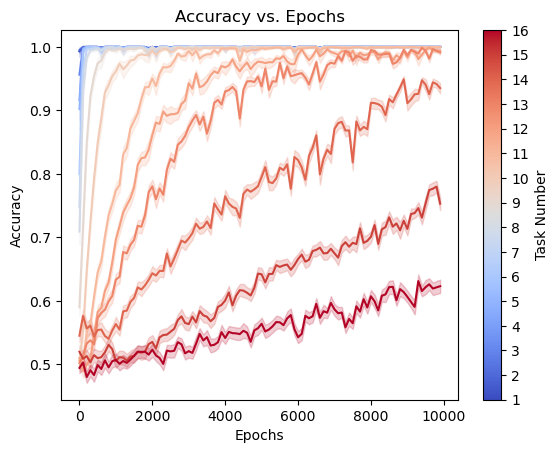

In [13]:
# Define the moving average window
moving_avg = 100
#eff_num_epochs = num_epochs // task_sample_freq
eff_num_epochs = math.ceil(num_epochs // task_sample_freq) #might be good for off_by_one errors

# Calculate the filtered epochs
epochs = np.arange(0, eff_num_epochs, moving_avg)
filtered_epochs = epochs[:len(epochs)//moving_avg * moving_avg]
scaled_filtered_epochs = [x * task_sample_freq for x in filtered_epochs]
print('epochs = ',epochs)
print('filtered_epochs = ', filtered_epochs)
print('scaled_filtered_epochs = ', scaled_filtered_epochs)
# Create an empty DataFrame
df = pd.DataFrame()

# Loop over the tasks and reshape the accuracy array
for i in range(n_tasks): # THere is strange bug I don't understand when moving_avg is certain values, such as 4
    reshaped_accuracy_array = np.reshape(accuracy_array[i], (-1, moving_avg))
    #print('len(np.repeat(filtered_epochs, moving_avg)) = ', len(np.repeat(filtered_epochs, moving_avg)))
    #print('len(np.ndarray.flatten(reshaped_accuracy_array)) = ', len(np.ndarray.flatten(reshaped_accuracy_array)))
    # Create a temporary DataFrame for the current task
    temp_df = pd.DataFrame({
        'Epochs': np.repeat(scaled_filtered_epochs, moving_avg),
        'Accuracy': np.ndarray.flatten(reshaped_accuracy_array),
        'Task': i + 1
    })
    
    # Concatenate the temporary DataFrame to the main DataFrame
    df = pd.concat([df, temp_df])
    
# Create a colourbar plot for different tasks, in seaborn. Useful for smoothing stuff out a bit.
# It was getting a bit hard to read with the very high variability.

# Define the color map
color_map = 'coolwarm'  # Change the color map here

# Plotting the data using seaborn
sns.lineplot(data=df, x='Epochs', y='Accuracy', errorbar=('ci', 95), estimator='mean', hue='Task', palette=color_map)

# Add plot labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

sm = plt.cm.ScalarMappable(cmap=color_map)
sm.set_array(range(1, n_tasks + 1))
#plt.colorbar(sm, ticks=np.arange(1, n_tasks + 1, int(n_tasks+1)/10), label='Task Number')
plt.colorbar(sm, ticks=np.linspace(1, n_tasks + 2, n_tasks+1, dtype=int), label='Task Number')

# Remove the legend inside the plot
plt.legend().remove()

# Show the plot
plt.show()

In [14]:
# Finding the later parts of the plot

# Creating the task-based accuracy plot. Now encapsulated in the acc_by_task_plot function.
#num_epochs = 10000 # change this to whenever the above run was stopped
# Define the moving average window
moving_avg = 10
#eff_num_epochs = num_epochs // task_sample_freq
#eff_num_epochs = math.ceil(num_epochs // task_sample_freq) #might be good for off_by_one errors

# Calculate the filtered epochs
epochs = np.arange(5000, eff_num_epochs+5000, moving_avg)
filtered_epochs = epochs[:len(epochs)//moving_avg * moving_avg]
scaled_filtered_epochs = [x * task_sample_freq for x in filtered_epochs]
print('epochs = ',epochs)
print('filtered_epochs = ', filtered_epochs)
print('scaled_filtered_epochs = ', scaled_filtered_epochs)
# Create an empty DataFrame
df = pd.DataFrame()

# Loop over the tasks and reshape the accuracy array
for i in range(n_tasks): # THere is strange bug I don't understand when moving_avg is certain values, such as 4
    reshaped_accuracy_array = np.reshape(accuracy_array_copy[i], (-1, moving_avg))
    print('len(np.repeat(filtered_epochs, moving_avg)) = ', len(np.repeat(filtered_epochs, moving_avg)))
    print('len(np.ndarray.flatten(reshaped_accuracy_array)) = ', len(np.ndarray.flatten(reshaped_accuracy_array)))
    # Create a temporary DataFrame for the current task
    temp_df = pd.DataFrame({
        'Epochs': np.repeat(scaled_filtered_epochs, moving_avg),
        'Accuracy': np.ndarray.flatten(reshaped_accuracy_array),
        'Task': i + 1
    })
    
    # Concatenate the temporary DataFrame to the main DataFrame
    df = pd.concat([df, temp_df])
    
# Create a colourbar plot for different tasks, in seaborn. Useful for smoothing stuff out a bit.
# It was getting a bit hard to read with the very high variability.

# Define the color map
color_map = 'coolwarm'  # Change the color map here

# Plotting the data using seaborn
sns.lineplot(data=df, x='Epochs', y='Accuracy', errorbar=('ci', 95), estimator='mean', hue='Task', palette=color_map)

# Add plot labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

sm = plt.cm.ScalarMappable(cmap=color_map)
sm.set_array(range(1, n_tasks + 1))
#plt.colorbar(sm, ticks=np.arange(1, n_tasks + 1, int(n_tasks+1)/10), label='Task Number')
plt.colorbar(sm, ticks=np.linspace(1, n_tasks + 2, n_tasks+1, dtype=int), label='Task Number')

# Remove the legend inside the plot
plt.legend().remove()

# Show the plot
plt.show()

epochs =  [ 5000  5010  5020  5030  5040  5050  5060  5070  5080  5090  5100  5110
  5120  5130  5140  5150  5160  5170  5180  5190  5200  5210  5220  5230
  5240  5250  5260  5270  5280  5290  5300  5310  5320  5330  5340  5350
  5360  5370  5380  5390  5400  5410  5420  5430  5440  5450  5460  5470
  5480  5490  5500  5510  5520  5530  5540  5550  5560  5570  5580  5590
  5600  5610  5620  5630  5640  5650  5660  5670  5680  5690  5700  5710
  5720  5730  5740  5750  5760  5770  5780  5790  5800  5810  5820  5830
  5840  5850  5860  5870  5880  5890  5900  5910  5920  5930  5940  5950
  5960  5970  5980  5990  6000  6010  6020  6030  6040  6050  6060  6070
  6080  6090  6100  6110  6120  6130  6140  6150  6160  6170  6180  6190
  6200  6210  6220  6230  6240  6250  6260  6270  6280  6290  6300  6310
  6320  6330  6340  6350  6360  6370  6380  6390  6400  6410  6420  6430
  6440  6450  6460  6470  6480  6490  6500  6510  6520  6530  6540  6550
  6560  6570  6580  6590  6600  6610  662

ValueError: All arrays must be of the same length